In [1]:
#####################################################
# Author: Prof. Marc Jofre
# Dept. Network Engineering
# Universitat Politècnica de Catalunya - Technical University of Catalonia
#
# Modified: 2025
# Created: 2024
#
# Script Quantum LAN application Dealer layer
#####################################################
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>") # Restart the kernel to clean up previous
#####################################################
# To avoid Jupyter kernel crash, provide the VM with enough RAM and CPUs (tens of GB RAM and at least 6 CPUs)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # Disable timeouts, but produces the extra internal info shown in the cells outputs
from IPython.display import clear_output
# sudo apt install libgl1-mesa-dev
#####################################################
import sys, os, subprocess, re, signal, gc
#!pip install --upgrade pip
#!pip install --upgrade pillow
#!pip install matplotlib
#!pip install numpy
import scipy
import numpy as np
#%matplotlib inline
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('default')
#mpl.use('Agg')  # Non-interactive backend
import time

#####################################################
# Do it once at the machine, to set the maximum buffer size. To avoied crashes because of memory issues:
#!jupyter notebook --generate-config
# Writing default config to: /home/marcjofre/.jupyter/jupyter_notebook_config.py
# nano ~/.jupyter/jupyter_notebook_config.py
# c.NotebookApp.max_buffer_size = 4294967296  # 4GB (adjust as needed)
## If kernel dies after a matplotlib plot: Reduce plot size!!!
# %matplotlib inline

pathScriptBelowAgentScript='./CppScripts/'
sys.path.append(pathScriptBelowAgentScript)
pathScriptBelowAgentScript='./JupyterPythonScripts/'
sys.path.append(pathScriptBelowAgentScript)
pathScriptData='../../GeneratedDataPythonJupyter/'

def GeneralSettingsPlots():
  SMALL_SIZE = 6
  MEDIUM_SIZE = 8
  BIGGER_SIZE = 9

  plt.rc('figure', figsize=[4.0, 3.0])     # controls default Figure size. Default is [6.4, 4.8]
  plt.rc('figure', autolayout = True)      # code will produce the same graphs on differently-configured machines
  plt.rc('font', size=MEDIUM_SIZE)         # controls default text sizes
  plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
  plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
  plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
  plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
  plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
  plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
  plt.rc('lines', linewidth=2) # 1 line width
  plt.rc('lines', markersize=10) # 6 marker size
GeneralSettingsPlots()

In [2]:
import QpresentationLayerAgent
# If needed to reload the module above without re-initializing
#import importlib
#importlib.reload(QpresentationLayerAgent)

#####################################################
# Parameters
## Network
IPhostDealerOpNet = "127.0.0.3"#10.0.0.4" # IP address of the dealer host (this host) in the operational network
IPhostDealerConNet = "10.0.0.4"#"192.168.10.1" # IP address of the dealer host (this host) in the control/configuration network
IPnodeDealerConNet = "10.0.0.252"#"192.168.10.2" # IP address of the dealer node (connected to the dealer host) in the control/configuration network
IPhostServerOpNet = "127.0.0.2"#"10.0.0.3" # IP address of the server host (this host) in the operational network
IPnodeServerConNet = "10.0.0.253"#"192.168.9.2" # IP address of the server node (connected to the server host) in the control/configuration network
IPhostClientOpNet = "127.0.0.1"#"10.0.0.1" # IP address of the host client (connected to the server host) in the operational network
IPnodeClientConNet = "10.0.0.254"#"192.168.8.2" # IP address of the client node (connecte to the client host) in the control/configuration network

# Hard coded correspondence tables identifying quad group channels for automatic synchronization periodic operations
# The order is stablished due to the physical connections between nodes, where the logical order follows the IPaddressesSockets in QtransportLayerAgentH.h for toehr OpNet nodes
ParamsTableAutoSynchQuadChEmt = "1;2;" # Coded from 1 to 7 (0 would not select any quad group channel) emit
ParamsTableAutoSynchQuadChDet = "2;1;" # Coded from 1 to 7 (0 would not select any quad group channel) detect

ParamsDealerListChar = ["dealer",IPnodeDealerConNet,IPhostDealerConNet,IPhostDealerOpNet,IPhostServerOpNet,IPhostClientOpNet]
ParamsDealerListChar.append(ParamsTableAutoSynchQuadChEmt)
ParamsDealerListChar.append(ParamsTableAutoSynchQuadChDet)
##############################################################
# Functions
def ListCharArrayParser(ListCharArrayAux):
    # Actually concatenating a python list of strings to a single string
    ParsedCharArrayAux=",".join(ListCharArrayAux)+","
    return ParsedCharArrayAux

def kill_udp_connections(ip: str, port: int, sudo: bool = False):
    """
    Kills all processes with UDP connections to the specified IP and port.
    
    Args:
        ip: Target IP address (e.g., "192.168.1.100")
        port: Target UDP port (e.g., 8010)
        sudo: Whether to use sudo (default True)
    
    Returns:
        Tuple[str, List[int]]: Command output and list of killed process IDs
    """
    cmd = f"ss -uapn"
    if sudo:
        cmd = f"sudo {cmd}"
    
    try:
        output = subprocess.check_output(cmd, shell=True, stderr=subprocess.STDOUT).decode()
    except subprocess.CalledProcessError as e:
        return e.output.decode(), []

    killed_pids = []
    filtered_lines = []

    for line in output.splitlines():
        if f"{ip}:{port}" in line:
            filtered_lines.append(line)
            match = re.search(r'pid=(\d+)', line)
            if match:
                try:
                    pid = int(match.group(1))
                    os.kill(pid, 9)  # SIGKILL
                    killed_pids.append(pid)
                except (ProcessLookupError, PermissionError):
                    continue

    return "\n".join(filtered_lines), killed_pids

# Example call:
output, killed = kill_udp_connections("127.0.0.4", 8010)
print(f"killed IP:Port old PID: {killed}")
output, killed = kill_udp_connections("10.0.0.4", 8010)
print(f"killed IP:Port old PID: {killed}")

# The parameters passed and received from agents are structured
ParamsAscendingCharArray = "none"
ParamsDescendingCharArray = ListCharArrayParser(ParamsDealerListChar)

### RUN UP TO HERE (INCLUDED) TO INITIALIZE CONNECTIONS AND THREAD QtransportLayerAgentH thread #####
# At this point, in this order, the node in the server has been initialized, the node in the client, the server host (up to this equivalent point) and then the client host (up to here)
# Create instance of Agent below
QPLAagent = QpresentationLayerAgent.QPLA(ParamsDescendingCharArray,ParamsAscendingCharArray)
def signal_handler(signal_received,frame):
    print(f'Signal {signal_received} received, exiting gracefully.')
    # Perform any cleanup here
    del QPLAagent
    sys.exit(0)

# Set up signal handlers
signal.signal(signal.SIGINT, signal_handler)  # Handle Ctrl+C
signal.signal(signal.SIGPIPE, signal_handler) # Handle broken pipe errors
#signal.signal(signal.SIGSEGV, signal_handler) # Handle segmentation faults (typically memory errors)
signal.signal(signal.SIGHUP, signal_handler) # Handle when terminal window is closed
signal.signal(signal.SIGTERM, signal_handler) # Termination request
### Initiate thread process in QtransportLayerAgentH
QPLAagent.InitAgentProcess() # Initialize the thread in QtransportLayerAgentH

killed IP:Port old PID: []
killed IP:Port old PID: []


<function _signal.default_int_handler(signalnum, frame, /)>

<Handlers.SIG_IGN: 1>

<Handlers.SIG_DFL: 0>

<Handlers.SIG_DFL: 0>

Host starting socket server to host/node: 10.0.0.252
Host starting socket server to host/node: 127.0.0.2
Host starting socket server to host/node: 127.0.0.1
Host client connected to server: 10.0.0.252
Host client connected to server: 127.0.0.2
Host client connected to server: 127.0.0.1
Starting in pause state the QtransportLayerAgentH
Node 10.0.0.252 hardware NOT synched...
Node 10.0.0.252 hardware NOT synched...
Node 10.0.0.252 hardware NOT synched...
Node 10.0.0.252 hardware NOT synched...
Node 10.0.0.252 hardware NOT synched...
Node 10.0.0.252 hardware NOT synched...
Node 10.0.0.252 hardware NOT synched...
Node 10.0.0.252 hardware NOT synched...
Node 10.0.0.252 hardware synched. Proceed with the network synchronization...
Another pair of nodes 127.0.0.2 and 127.0.0.3 synch iteration completed!
Host 127.0.0.3 synching node 10.0.0.252 to the network!
Host 127.0.0.3 synched node 10.0.0.252 to the network!
Another pair of nodes 127.0.0.1 and 127.0.0.3 synch iteration completed!


In [ ]:
#####################
# Some tests to send information to the different elements and see them output at the respective console
# The required fields of a message are (separated by commas): IPdestination,IPorigin,Type,Command,Payload
messagePayloadAux="Host dealer sends information to attached node"
messageCommandAux="print"
messageTypeAux="Control"
messageIPorg=IPhostDealerOpNet
messageIPdest=IPnodeDealerConNet
messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
QPLAagent.SendMessageAgent(messageAuxChar)

messagePayloadAux="Host dealer sends information to server host"
messageCommandAux="print"
messageTypeAux="Operation"
messageIPorg=IPhostDealerOpNet
messageIPdest=IPhostServerOpNet
messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
QPLAagent.SendMessageAgent(messageAuxChar)

messagePayloadAux="Host dealer sends information to host server node"
messageCommandAux="print"
messageTypeAux="Control"
messageIPorg=IPhostDealerOpNet
messageIPdest=IPhostServerOpNet # Notice that it is send to the host (which it will forward it to the node)
messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
QPLAagent.SendMessageAgent(messageAuxChar)

messagePayloadAux="Host dealer sends information to client host"
messageCommandAux="print"
messageTypeAux="Operation"
messageIPorg=IPhostDealerOpNet
messageIPdest=IPhostClientOpNet
messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
QPLAagent.SendMessageAgent(messageAuxChar)

messagePayloadAux="Host dealer sends information to host client node"
messageCommandAux="print"
messageTypeAux="Control"
messageIPorg=IPhostDealerOpNet
messageIPdest=IPhostClientOpNet # Notice that it is send to the host (which it will forward it to the node)
messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
QPLAagent.SendMessageAgent(messageAuxChar)

In [ ]:
#### Some test to send entangled QuBits from the dealer to two other hosts #################
QuadChEmtDet=np.asarray([3,2,1]) # Emit, Detect, Detect
SynchPRUoffFreqVal=np.asarray([0.0,0.0])# Double value to adjust synch signals offset and frequency for each quantum channel
PeriodSignalHistVal=4096.0# Histogram/Period sending/receiving signals. Power of 2!
NumRequestedQubitsSend=65536 # Qubits to send
NumRequestedQubitsReceive=1964# Qubits signals to detect
argsPayloadBlockUnblockList=[IPhostClientOpNet,IPhostServerOpNet]
QPLAagent.WaitUntilActiveActionFreePreLock(argsPayloadBlockUnblockList)
QPLAagent.SimulateSendEntangledQubitsHost(IPhostClientOpNet,IPhostDealerOpNet,IPhostServerOpNet,IPhostDealerOpNet,IPnodeDealerConNet,IPhostDealerConNet,NumRequestedQubitsSend,NumRequestedQubitsReceive,PeriodSignalHistVal,SynchPRUoffFreqVal,QuadChEmtDet) # Request that the other nodes of the specified hosts get ready to receive entangled qubits from the dealer's node
NumStoredQubitsNode1 = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
StatisticsTimeTagDetStoredQubitsNode1 = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPhostClientOpNet,IPhostDealerOpNet,NumStoredQubitsNode1,StatisticsTimeTagDetStoredQubitsNode1) # Supposing that node has received quBits, return number of QuBits
print('NumStoredQubitsNode1[0]: '+str(NumStoredQubitsNode1[0]))
print('StatisticsTimeTagDetStoredQubitsNode1: '+str(StatisticsTimeTagDetStoredQubitsNode1))
NumStoredQubitsNode2 = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
StatisticsTimeTagDetStoredQubitsNode2 = np.zeros(8, dtype=np.double)# equivalnet to float64for C like arrays
QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPhostServerOpNet,IPhostDealerOpNet,NumStoredQubitsNode2,StatisticsTimeTagDetStoredQubitsNode2) # Supposing that node has received quBits, return number of QuBits
QPLAagent.UnBlockActiveActionFreePreLock(argsPayloadBlockUnblockList)
print('NumStoredQubitsNode2[0]: '+str(NumStoredQubitsNode2[0]))
print('StatisticsTimeTagDetStoredQubitsNode2: '+str(StatisticsTimeTagDetStoredQubitsNode2))

In [ ]:
###### Hard resilience test #######
clear_output(wait=True)
import random
import time
NumTestMax = 1000
ListNumStoredQubitsNode1=[]
ListStatisticsTimeTaggDetQubitsNode1Param0=[]
ListStatisticsTimeTaggDetQubitsNode1Param1=[]
ListStatisticsTimeTaggDetQubitsNode1Param2=[]
ListStatisticsTimeTaggDetQubitsNode1Param3=[]
ListStatisticsTimeTaggDetQubitsNode1Param4=[]
ListStatisticsTimeTaggDetQubitsNode1Param5=[]
ListStatisticsTimeTaggDetQubitsNode1Param6=[]
ListStatisticsTimeTaggDetQubitsNode1Param7=[]
ListNumStoredQubitsNode2=[]
ListStatisticsTimeTaggDetQubitsNode2Param0=[]
ListStatisticsTimeTaggDetQubitsNode2Param1=[]
ListStatisticsTimeTaggDetQubitsNode2Param2=[]
ListStatisticsTimeTaggDetQubitsNode2Param3=[]
ListStatisticsTimeTaggDetQubitsNode2Param4=[]
ListStatisticsTimeTaggDetQubitsNode2Param5=[]
ListStatisticsTimeTaggDetQubitsNode2Param6=[]
ListStatisticsTimeTaggDetQubitsNode2Param7=[]
for iIterTest in range(0,NumTestMax,1):
    RandomTestNum=random.randint(0, 1)
    if (RandomTestNum==0):
        # Sending messages
        messagePayloadAux="Host dealer sends information to attached node"
        messageCommandAux="print"
        messageTypeAux="Control"
        messageIPorg=IPhostDealerOpNet
        messageIPdest=IPnodeDealerConNet
        messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
        QPLAagent.SendMessageAgent(messageAuxChar)
        time.sleep(0.1)
        messagePayloadAux="Host dealer sends information to server host"
        messageCommandAux="print"
        messageTypeAux="Operation"
        messageIPorg=IPhostDealerOpNet
        messageIPdest=IPhostServerOpNet
        messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
        QPLAagent.SendMessageAgent(messageAuxChar)
        time.sleep(0.1)
        messagePayloadAux="Host dealer sends information to host server node"
        messageCommandAux="print"
        messageTypeAux="Control"
        messageIPorg=IPhostDealerOpNet
        messageIPdest=IPhostServerOpNet # Notice that it is send to the host (which it will forward it to the node)
        messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
        QPLAagent.SendMessageAgent(messageAuxChar)
        time.sleep(0.1)
        messagePayloadAux="Host dealer sends information to client host"
        messageCommandAux="print"
        messageTypeAux="Operation"
        messageIPorg=IPhostDealerOpNet
        messageIPdest=IPhostClientOpNet
        messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
        QPLAagent.SendMessageAgent(messageAuxChar)
        time.sleep(0.1)
        messagePayloadAux="Host dealer sends information to host client node"
        messageCommandAux="print"
        messageTypeAux="Control"
        messageIPorg=IPhostDealerOpNet
        messageIPdest=IPhostClientOpNet # Notice that it is send to the host (which it will forward it to the node)
        messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
        QPLAagent.SendMessageAgent(messageAuxChar)      
    else:
        # Sending Entangled QuBits
        QuadChEmtDet=np.asarray([3,2,1]) # Emit, Detect, Detect
        SynchPRUoffFreqVal=np.asarray([0.0,0.0])# Double value to adjust synch signals offset and frequency for each quantum channel
        PeriodSignalHistVal=4096.0# Histogram/Period sending/receiving signals. Power of 2!
        NumRequestedQubitsSend=65536 # Qubits to send
        NumRequestedQubitsReceive=1964# Qubits signals to detect
        argsPayloadBlockUnblockList=[IPhostClientOpNet,IPhostServerOpNet]
        QPLAagent.WaitUntilActiveActionFreePreLock(argsPayloadBlockUnblockList)
        QPLAagent.SimulateSendEntangledQubitsHost(IPhostClientOpNet,IPhostDealerOpNet,IPhostServerOpNet,IPhostDealerOpNet,IPnodeDealerConNet,IPhostDealerConNet,NumRequestedQubitsSend,NumRequestedQubitsReceive,PeriodSignalHistVal,SynchPRUoffFreqVal,QuadChEmtDet) # Request that the other nodes of the specified hosts get ready to receive entangled qubits from the dealer's node
        NumStoredQubitsNode1 = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
        StatisticsTimeTagDetStoredQubitsNode1 = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
        QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPhostClientOpNet,IPhostDealerOpNet,NumStoredQubitsNode1,StatisticsTimeTagDetStoredQubitsNode1) # Supposing that node has received quBits, return number of QuBits
        NumStoredQubitsNode2 = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
        StatisticsTimeTagDetStoredQubitsNode2 = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
        QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPhostServerOpNet,IPhostDealerOpNet,NumStoredQubitsNode2,StatisticsTimeTagDetStoredQubitsNode2) # Supposing that node has received quBits, return number of QuBits
        QPLAagent.UnBlockActiveActionFreePreLock(argsPayloadBlockUnblockList)
        ListNumStoredQubitsNode1.append(NumStoredQubitsNode1[0])
        ListStatisticsTimeTaggDetQubitsNode1Param0.append(StatisticsTimeTagDetStoredQubitsNode1[0])
        ListStatisticsTimeTaggDetQubitsNode1Param1.append(StatisticsTimeTagDetStoredQubitsNode1[1])
        ListStatisticsTimeTaggDetQubitsNode1Param2.append(StatisticsTimeTagDetStoredQubitsNode1[2])
        ListStatisticsTimeTaggDetQubitsNode1Param3.append(StatisticsTimeTagDetStoredQubitsNode1[3])
        ListStatisticsTimeTaggDetQubitsNode1Param4.append(StatisticsTimeTagDetStoredQubitsNode1[4])
        ListStatisticsTimeTaggDetQubitsNode1Param5.append(StatisticsTimeTagDetStoredQubitsNode1[5])
        ListStatisticsTimeTaggDetQubitsNode1Param6.append(StatisticsTimeTagDetStoredQubitsNode1[6])
        ListStatisticsTimeTaggDetQubitsNode1Param7.append(StatisticsTimeTagDetStoredQubitsNode1[7])
        ListNumStoredQubitsNode2.append(NumStoredQubitsNode2[0])
        ListStatisticsTimeTaggDetQubitsNode2Param0.append(StatisticsTimeTagDetStoredQubitsNode2[0])
        ListStatisticsTimeTaggDetQubitsNode2Param1.append(StatisticsTimeTagDetStoredQubitsNode2[1])
        ListStatisticsTimeTaggDetQubitsNode2Param2.append(StatisticsTimeTagDetStoredQubitsNode2[2])
        ListStatisticsTimeTaggDetQubitsNode2Param3.append(StatisticsTimeTagDetStoredQubitsNode2[3])
        ListStatisticsTimeTaggDetQubitsNode2Param4.append(StatisticsTimeTagDetStoredQubitsNode2[4])
        ListStatisticsTimeTaggDetQubitsNode2Param5.append(StatisticsTimeTagDetStoredQubitsNode2[5])
        ListStatisticsTimeTaggDetQubitsNode2Param6.append(StatisticsTimeTagDetStoredQubitsNode2[6])
        ListStatisticsTimeTaggDetQubitsNode2Param7.append(StatisticsTimeTagDetStoredQubitsNode2[7])
    time.sleep(10.0)
    time.sleep(int(15.0*random.uniform(0,1)))
print('ListNumStoredQubitsNode1: '+str(ListNumStoredQubitsNode1))
print('ListStatisticsTimeTaggDetQubitsNode1Param0: '+str(ListStatisticsTimeTaggDetQubitsNode1Param0))
print('ListStatisticsTimeTaggDetQubitsNode1Param1: '+str(ListStatisticsTimeTaggDetQubitsNode1Param1))
print('ListStatisticsTimeTaggDetQubitsNode1Param2: '+str(ListStatisticsTimeTaggDetQubitsNode1Param2))
print('ListStatisticsTimeTaggDetQubitsNode1Param3: '+str(ListStatisticsTimeTaggDetQubitsNode1Param3))
print('ListStatisticsTimeTaggDetQubitsNode1Param4: '+str(ListStatisticsTimeTaggDetQubitsNode1Param4))
print('ListStatisticsTimeTaggDetQubitsNode1Param5: '+str(ListStatisticsTimeTaggDetQubitsNode1Param5))
print('ListStatisticsTimeTaggDetQubitsNode1Param6: '+str(ListStatisticsTimeTaggDetQubitsNode1Param6))
print('ListStatisticsTimeTaggDetQubitsNode1Param7: '+str(ListStatisticsTimeTaggDetQubitsNode1Param7))
print('ListNumStoredQubitsNode2: '+str(ListNumStoredQubitsNode2))
print('ListStatisticsTimeTaggDetQubitsNode2Param0: '+str(ListStatisticsTimeTaggDetQubitsNode2Param0))
print('ListStatisticsTimeTaggDetQubitsNode2Param1: '+str(ListStatisticsTimeTaggDetQubitsNode2Param1))
print('ListStatisticsTimeTaggDetQubitsNode2Param2: '+str(ListStatisticsTimeTaggDetQubitsNode2Param2))
print('ListStatisticsTimeTaggDetQubitsNode2Param3: '+str(ListStatisticsTimeTaggDetQubitsNode2Param3))
print('ListStatisticsTimeTaggDetQubitsNode2Param4: '+str(ListStatisticsTimeTaggDetQubitsNode2Param4))
print('ListStatisticsTimeTaggDetQubitsNode2Param5: '+str(ListStatisticsTimeTaggDetQubitsNode2Param5))
print('ListStatisticsTimeTaggDetQubitsNode2Param6: '+str(ListStatisticsTimeTaggDetQubitsNode2Param6))
print('ListStatisticsTimeTaggDetQubitsNode2Param7: '+str(ListStatisticsTimeTaggDetQubitsNode2Param7))

In [ ]:
# Save generated data
clear_output(wait=True)
ExtraDetailString='PTP'#'NoPTP'#'NoPTP'
np.save(pathScriptData+'DealerListNumStoredQubitsNode1'+ExtraDetailString,ListNumStoredQubitsNode1)
np.save(pathScriptData+'DealerListNumStoredQubitsCh1Node1'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode1Param0)
np.save(pathScriptData+'DealerListNumStoredQubitsCh2Node1'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode1Param1)
np.save(pathScriptData+'DealerListNumStoredQubitsCh3Node1'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode1Param2)
np.save(pathScriptData+'DealerListNumStoredQubitsCh4Node1'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode1Param3)
np.save(pathScriptData+'DealerListNumStoredQubitsMultiNode1'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode1Param4)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode1'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode1Param5)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode1'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode1Param6)
np.save(pathScriptData+'DealerListNumStoredQubitsTabsNode1'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode1Param7)
np.save(pathScriptData+'DealerListNumStoredQubitsNode2'+ExtraDetailString,ListNumStoredQubitsNode2)
np.save(pathScriptData+'DealerListNumStoredQubitsCh1Node2'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode2Param0)
np.save(pathScriptData+'DealerListNumStoredQubitsCh2Node2'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode2Param1)
np.save(pathScriptData+'DealerListNumStoredQubitsCh3Node2'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode2Param2)
np.save(pathScriptData+'DealerListNumStoredQubitsCh4Node2'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode2Param3)
np.save(pathScriptData+'DealerListNumStoredQubitsMultiNode2'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode2Param4)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode2'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode2Param5)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode2'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode2Param6)
np.save(pathScriptData+'DealerListNumStoredQubitsTabsNode2'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode2Param7)

In [ ]:
# Plot ListNumStoredQubitsNode data
clear_output(wait=True)
gc.collect() # Garbage collector to avoid kernel crashes
HistPeriodicityAux=PeriodSignalHistVal# Histogram analysis periodicity
ExtraDetailString='PTP'#'NoPTP'#'NoPTP'
### Node 1
ListNumStoredQubitsNode=np.load(pathScriptData+'DealerListNumStoredQubitsNode1'+ExtraDetailString+'.npy')
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListNumStoredQubitsNode,bins=np.arange(0,HistPeriodicityAux,16))
plt.xlabel('QuBits')
plt.ylabel('hist. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

ListStatisticsTimeTaggDetQubitsNodeParam0=np.load(pathScriptData+'DealerListNumStoredQubitsCh1Node1'+ExtraDetailString+'.npy')
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListStatisticsTimeTaggDetQubitsNodeParam0,bins=np.arange(0,HistPeriodicityAux,16))
plt.xlabel('QuBits')
plt.ylabel('Ch1 hist. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

ListStatisticsTimeTaggDetQubitsNodeParam1=np.load(pathScriptData+'DealerListNumStoredQubitsCh2Node1'+ExtraDetailString+'.npy')
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListStatisticsTimeTaggDetQubitsNodeParam1,bins=np.arange(0,HistPeriodicityAux,16))
plt.xlabel('QuBits')
plt.ylabel('Ch2 hist. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

ListStatisticsTimeTaggDetQubitsNodeParam2=np.load(pathScriptData+'DealerListNumStoredQubitsCh3Node1'+ExtraDetailString+'.npy')
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListStatisticsTimeTaggDetQubitsNodeParam2,bins=np.arange(0,HistPeriodicityAux,16))
plt.xlabel('QuBits')
plt.ylabel('Ch3 hist. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

ListStatisticsTimeTaggDetQubitsNodeParam3=np.load(pathScriptData+'DealerListNumStoredQubitsCh4Node1'+ExtraDetailString+'.npy')
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListStatisticsTimeTaggDetQubitsNodeParam3,bins=np.arange(0,HistPeriodicityAux,16))
plt.xlabel('QuBits')
plt.ylabel('Ch4 hist. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

ListStatisticsTimeTaggDetQubitsNodeParam4=np.load(pathScriptData+'DealerListNumStoredQubitsMultiNode1'+ExtraDetailString+'.npy')
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListNumStoredQubitsNode,bins=np.arange(0,HistPeriodicityAux,16))
plt.xlabel('QuBits')
plt.ylabel('Multi Ch. hist. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

ListStatisticsTimeTaggDetQubitsNodeParam5=np.load(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode1'+ExtraDetailString+'.npy')
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam5),1),ListStatisticsTimeTaggDetQubitsNodeParam5)
plt.xlabel('Det. run')
plt.ylabel('Time diff avg. [count]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

ListStatisticsTimeTaggDetQubitsNodeParam6=np.load(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode1'+ExtraDetailString+'.npy')
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam6),1),ListStatisticsTimeTaggDetQubitsNodeParam6)
plt.xlabel('Det. run')
plt.ylabel('Time. diff. std [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

ListStatisticsTimeTaggDetQubitsNodeParam7=np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode1'+ExtraDetailString+'.npy')
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7),1),ListStatisticsTimeTaggDetQubitsNodeParam7)
plt.xlabel('Det. run')
plt.ylabel('Time. abs [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

##########################################################################################################
## Node 2
ListNumStoredQubitsNode=np.load(pathScriptData+'DealerListNumStoredQubitsNode2'+ExtraDetailString+'.npy')
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListNumStoredQubitsNode,bins=np.arange(0,HistPeriodicityAux,16))
plt.xlabel('QuBits')
plt.ylabel('hist. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

ListStatisticsTimeTaggDetQubitsNodeParam0=np.load(pathScriptData+'DealerListNumStoredQubitsCh1Node2'+ExtraDetailString+'.npy')
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListStatisticsTimeTaggDetQubitsNodeParam0,bins=np.arange(0,HistPeriodicityAux,16))
plt.xlabel('QuBits')
plt.ylabel('Ch1 hist. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

ListStatisticsTimeTaggDetQubitsNodeParam1=np.load(pathScriptData+'DealerListNumStoredQubitsCh2Node2'+ExtraDetailString+'.npy')
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListStatisticsTimeTaggDetQubitsNodeParam1,bins=np.arange(0,HistPeriodicityAux,16))
plt.xlabel('QuBits')
plt.ylabel('Ch2 hist. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

ListStatisticsTimeTaggDetQubitsNodeParam2=np.load(pathScriptData+'DealerListNumStoredQubitsCh3Node2'+ExtraDetailString+'.npy')
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListStatisticsTimeTaggDetQubitsNodeParam2,bins=np.arange(0,HistPeriodicityAux,16))
plt.xlabel('QuBits')
plt.ylabel('Ch3 hist. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

ListStatisticsTimeTaggDetQubitsNodeParam3=np.load(pathScriptData+'DealerListNumStoredQubitsCh4Node2'+ExtraDetailString+'.npy')
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListStatisticsTimeTaggDetQubitsNodeParam3,bins=np.arange(0,HistPeriodicityAux,16))
plt.xlabel('QuBits')
plt.ylabel('Ch4 hist. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

ListStatisticsTimeTaggDetQubitsNodeParam4=np.load(pathScriptData+'DealerListNumStoredQubitsMultiNode2'+ExtraDetailString+'.npy')
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListNumStoredQubitsNode,bins=np.arange(0,HistPeriodicityAux,16))
plt.xlabel('QuBits')
plt.ylabel('Multi Ch. hist. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

ListStatisticsTimeTaggDetQubitsNodeParam5=np.load(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode2'+ExtraDetailString+'.npy')
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam5),1),ListStatisticsTimeTaggDetQubitsNodeParam5)
plt.xlabel('Det. run')
plt.ylabel('Time diff avg. [count]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

ListStatisticsTimeTaggDetQubitsNodeParam6=np.load(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode2'+ExtraDetailString+'.npy')
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam6),1),ListStatisticsTimeTaggDetQubitsNodeParam6)
plt.xlabel('Det. run')
plt.ylabel('Time. diff. std [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

ListStatisticsTimeTaggDetQubitsNodeParam7=np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode2'+ExtraDetailString+'.npy')
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7),1),ListStatisticsTimeTaggDetQubitsNodeParam7)
plt.xlabel('Det. run')
plt.ylabel('Time. abs [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
#clear_output(wait=True)

In [ ]:
####### Debbuging synch intra runs - Sending a pair of qubits to different nodes
# Only channel 1 is connected
# PRU1 PRUassTrigSigScriptHist4Sig.p is used
# PTP protocol better enabled
# Tags statistics in QPhysLayer c++ is modified to this particular case

In [ ]:
clear_output(wait=True)
import random
import time
NumTestMax = 15
ListNumStoredQubitsNode1=[]
ListStatisticsTimeTaggDetQubitsNode1Param0=[]
ListStatisticsTimeTaggDetQubitsNode1Param1=[]
ListStatisticsTimeTaggDetQubitsNode1Param2=[]
ListStatisticsTimeTaggDetQubitsNode1Param3=[]
ListStatisticsTimeTaggDetQubitsNode1Param4=[]
ListStatisticsTimeTaggDetQubitsNode1Param5=[]
ListStatisticsTimeTaggDetQubitsNode1Param6=[]
ListStatisticsTimeTaggDetQubitsNode1Param7=[]
ListNumStoredQubitsNode2=[]
ListStatisticsTimeTaggDetQubitsNode2Param0=[]
ListStatisticsTimeTaggDetQubitsNode2Param1=[]
ListStatisticsTimeTaggDetQubitsNode2Param2=[]
ListStatisticsTimeTaggDetQubitsNode2Param3=[]
ListStatisticsTimeTaggDetQubitsNode2Param4=[]
ListStatisticsTimeTaggDetQubitsNode2Param5=[]
ListStatisticsTimeTaggDetQubitsNode2Param6=[]
ListStatisticsTimeTaggDetQubitsNode2Param7=[]
for iIterTest in range(0,NumTestMax,1):
    # Sending Entangled QuBits
    QuadChEmtDet=np.asarray([3,2,1]) # Emit, Detect, Detect
    SynchPRUoffFreqVal=np.asarray([0.0,0.0])# Double value to adjust synch signals offset and frequency for each quantum channel
    TestPeriodFactorAux=8.0 # (Sub)Power of 2!
    PeriodSignalHistVal=4096.0/TestPeriodFactorAux# Histogram/Period sending/receiving signals. Power of 2!
    NumRequestedQubitsSend=65536*TestPeriodFactorAux # Qubits to send
    NumRequestedQubitsReceive=1964# Qubits signals to detect
    argsPayloadBlockUnblockList=[IPhostClientOpNet,IPhostServerOpNet]
    QPLAagent.WaitUntilActiveActionFreePreLock(argsPayloadBlockUnblockList)
    QPLAagent.SimulateSendEntangledQubitsHost(IPhostClientOpNet,IPhostDealerOpNet,IPhostServerOpNet,IPhostDealerOpNet,IPnodeDealerConNet,IPhostDealerConNet,NumRequestedQubitsSend,NumRequestedQubitsReceive,PeriodSignalHistVal,SynchPRUoffFreqVal,QuadChEmtDet) # Request that the other nodes of the specified hosts get ready to receive entangled qubits from the dealer's node
    NumStoredQubitsNode1 = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode1 = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPhostClientOpNet,IPhostDealerOpNet,NumStoredQubitsNode1,StatisticsTimeTagDetStoredQubitsNode1) # Supposing that node has received quBits, return number of QuBits
    NumStoredQubitsNode2 = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode2 = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPhostServerOpNet,IPhostDealerOpNet,NumStoredQubitsNode2,StatisticsTimeTagDetStoredQubitsNode2) # Supposing that node has received quBits, return number of QuBits
    QPLAagent.UnBlockActiveActionFreePreLock(argsPayloadBlockUnblockList)
    ListNumStoredQubitsNode1.append(NumStoredQubitsNode1[0])
    ListStatisticsTimeTaggDetQubitsNode1Param0.append(StatisticsTimeTagDetStoredQubitsNode1[0])
    ListStatisticsTimeTaggDetQubitsNode1Param1.append(StatisticsTimeTagDetStoredQubitsNode1[1])
    ListStatisticsTimeTaggDetQubitsNode1Param2.append(StatisticsTimeTagDetStoredQubitsNode1[2])
    ListStatisticsTimeTaggDetQubitsNode1Param3.append(StatisticsTimeTagDetStoredQubitsNode1[3])
    ListStatisticsTimeTaggDetQubitsNode1Param4.append(StatisticsTimeTagDetStoredQubitsNode1[4])
    ListStatisticsTimeTaggDetQubitsNode1Param5.append(StatisticsTimeTagDetStoredQubitsNode1[5])
    ListStatisticsTimeTaggDetQubitsNode1Param6.append(StatisticsTimeTagDetStoredQubitsNode1[6])
    ListStatisticsTimeTaggDetQubitsNode1Param7.append(StatisticsTimeTagDetStoredQubitsNode1[7])
    ListNumStoredQubitsNode2.append(NumStoredQubitsNode2[0])
    ListStatisticsTimeTaggDetQubitsNode2Param0.append(StatisticsTimeTagDetStoredQubitsNode2[0])
    ListStatisticsTimeTaggDetQubitsNode2Param1.append(StatisticsTimeTagDetStoredQubitsNode2[1])
    ListStatisticsTimeTaggDetQubitsNode2Param2.append(StatisticsTimeTagDetStoredQubitsNode2[2])
    ListStatisticsTimeTaggDetQubitsNode2Param3.append(StatisticsTimeTagDetStoredQubitsNode2[3])
    ListStatisticsTimeTaggDetQubitsNode2Param4.append(StatisticsTimeTagDetStoredQubitsNode2[4])
    ListStatisticsTimeTaggDetQubitsNode2Param5.append(StatisticsTimeTagDetStoredQubitsNode2[5])
    ListStatisticsTimeTaggDetQubitsNode2Param6.append(StatisticsTimeTagDetStoredQubitsNode2[6])
    ListStatisticsTimeTaggDetQubitsNode2Param7.append(StatisticsTimeTagDetStoredQubitsNode2[7])
    time.sleep(5.0)
    time.sleep(int(5.0*random.uniform(0,1)))
    clear_output(wait=True)
    print("iIterTest: " +str(iIterTest+1))
print('ListNumStoredQubitsNode1: '+str(ListNumStoredQubitsNode1))
print('ListStatisticsTimeTaggDetQubitsNode1Param0: '+str(ListStatisticsTimeTaggDetQubitsNode1Param0))
print('ListStatisticsTimeTaggDetQubitsNode1Param1: '+str(ListStatisticsTimeTaggDetQubitsNode1Param1))
print('ListStatisticsTimeTaggDetQubitsNode1Param2: '+str(ListStatisticsTimeTaggDetQubitsNode1Param2))
print('ListStatisticsTimeTaggDetQubitsNode1Param3: '+str(ListStatisticsTimeTaggDetQubitsNode1Param3))
print('ListStatisticsTimeTaggDetQubitsNode1Param4: '+str(ListStatisticsTimeTaggDetQubitsNode1Param4))
print('ListStatisticsTimeTaggDetQubitsNode1Param5: '+str(ListStatisticsTimeTaggDetQubitsNode1Param5))
print('ListStatisticsTimeTaggDetQubitsNode1Param6: '+str(ListStatisticsTimeTaggDetQubitsNode1Param6))
print('ListStatisticsTimeTaggDetQubitsNode1Param7: '+str(ListStatisticsTimeTaggDetQubitsNode1Param7))
print('ListNumStoredQubitsNode2: '+str(ListNumStoredQubitsNode2))
print('ListStatisticsTimeTaggDetQubitsNode2Param0: '+str(ListStatisticsTimeTaggDetQubitsNode2Param0))
print('ListStatisticsTimeTaggDetQubitsNode2Param1: '+str(ListStatisticsTimeTaggDetQubitsNode2Param1))
print('ListStatisticsTimeTaggDetQubitsNode2Param2: '+str(ListStatisticsTimeTaggDetQubitsNode2Param2))
print('ListStatisticsTimeTaggDetQubitsNode2Param3: '+str(ListStatisticsTimeTaggDetQubitsNode2Param3))
print('ListStatisticsTimeTaggDetQubitsNode2Param4: '+str(ListStatisticsTimeTaggDetQubitsNode2Param4))
print('ListStatisticsTimeTaggDetQubitsNode2Param5: '+str(ListStatisticsTimeTaggDetQubitsNode2Param5))
print('ListStatisticsTimeTaggDetQubitsNode2Param6: '+str(ListStatisticsTimeTaggDetQubitsNode2Param6))
print('ListStatisticsTimeTaggDetQubitsNode2Param7: '+str(ListStatisticsTimeTaggDetQubitsNode2Param7))

In [ ]:
# Save generated data
clear_output(wait=True)
ExtraDetailString='PTP'#'PTPjitter'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'DealerListNumStoredQubitsNode1'+ExtraDetailString,ListNumStoredQubitsNode1)
np.save(pathScriptData+'DealerListNumStoredQubitsCh1Node1'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode1Param0)
np.save(pathScriptData+'DealerListNumStoredQubitsCh2Node1'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode1Param1)
np.save(pathScriptData+'DealerListNumStoredQubitsCh3Node1'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode1Param2)
np.save(pathScriptData+'DealerListNumStoredQubitsCh4Node1'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode1Param3)
np.save(pathScriptData+'DealerListNumStoredQubitsMultiNode1'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode1Param4)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode1'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode1Param5)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode1'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode1Param6)
np.save(pathScriptData+'DealerListNumStoredQubitsTabsNode1'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode1Param7)
np.save(pathScriptData+'DealerListNumStoredQubitsNode2'+ExtraDetailString,ListNumStoredQubitsNode2)
np.save(pathScriptData+'DealerListNumStoredQubitsCh1Node2'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode2Param0)
np.save(pathScriptData+'DealerListNumStoredQubitsCh2Node2'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode2Param1)
np.save(pathScriptData+'DealerListNumStoredQubitsCh3Node2'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode2Param2)
np.save(pathScriptData+'DealerListNumStoredQubitsCh4Node2'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode2Param3)
np.save(pathScriptData+'DealerListNumStoredQubitsMultiNode2'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode2Param4)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode2'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode2Param5)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode2'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode2Param6)
np.save(pathScriptData+'DealerListNumStoredQubitsTabsNode2'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode2Param7)

In [ ]:
## Synchronization analysis inter and intra runs
clear_output(wait=True)
gc.collect() # Garbage collector to avoid kernel crashes
# Connect on the timetagg part only channel 1
# It has to be used PRUassTrigSigScriptHist4Sig in PRU1
# Attention TimeTaggsDetAnalytics[5] stores the mean wrap count difference
# Attention TimeTaggsDetAnalytics[6] stores the std wrap count difference
ExtraDetailString='PTP'#'PTPjitter'#'NoPTP'# 'NTP'#'PTP'
#PeriodSignalHistVal=4096.0/32.0
HistPeriodicityAux=PeriodSignalHistVal# Histogram analysis periodicity
ListNumStoredQubitsNode=np.load(pathScriptData+'DealerListNumStoredQubitsNode1'+ExtraDetailString+'.npy')
NonZeroIndecesDet=np.where(ListNumStoredQubitsNode>0)[0]
ListStatisticsTimeTaggDetQubitsNodeParam5=(np.load(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode1'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam5),1),ListStatisticsTimeTaggDetQubitsNodeParam5)
plt.xlabel('Det. run')
plt.ylabel('Intra time. wrap diff. avg. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

ListStatisticsTimeTaggDetQubitsNodeParam6=(np.load(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode1'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam6),1),ListStatisticsTimeTaggDetQubitsNodeParam6)
plt.xlabel('Det. run')
plt.ylabel('Intra time. wrap diff. Std [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

print('Intra time. wrap diff. avg. [counts]: '+str(np.mean(ListStatisticsTimeTaggDetQubitsNodeParam5)))
print('Intra time. wrap diff. std [counts]: '+str(np.mean(ListStatisticsTimeTaggDetQubitsNodeParam6)))

#######################################################################################################
#Inter runs checker of the initial detection in channel 1
# The plot below helps adjust the Threshold value (we should a constantly increasing line - never a decrease jump)
# If the first out of place is a up-bump->threshold value too high
# If the first out of place is a down-bump->threshold value too low
ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode1'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(1,len(ListStatisticsTimeTaggDetQubitsNodeParam7),1),ListStatisticsTimeTaggDetQubitsNodeParam7[1:])
plt.xlabel('Det. run')
plt.ylabel('Inter time. abs. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode1'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
IntraRunSynchChecker=np.zeros(len(ListStatisticsTimeTaggDetQubitsNodeParam7)-2,dtype=np.float32)
for iIter in range(1,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1):    
    IntraRunSynchChecker[iIter-1]=ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+1]-ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+0]
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(1,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1),IntraRunSynchChecker)
plt.xlabel('Det. run')
plt.ylabel('Inter time. diff. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

## Zero Time Point
#ListStatisticsTimeTaggDetQubitsNodeParam7=ListStatisticsTimeTaggDetQubitsNodeParam7-ListStatisticsTimeTaggDetQubitsNodeParam7[0]

# Checking with wrapping
ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode1'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
IntraRunSynchChecker=np.zeros(len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,dtype=np.float32)
for iIter in range(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1):
    # Relative difference
    CalcAux=ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+1]-ListStatisticsTimeTaggDetQubitsNodeParam7[1*iIter]
    # Absolute difference with first tag
    #CalcAux=ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+1]-ListStatisticsTimeTaggDetQubitsNodeParam7[0*iIter]
    #NumCycles=np.round(CalcAux/HistPeriodicityAux)
    IntraRunSynchChecker[iIter]=(np.mod(HistPeriodicityAux/2.0+CalcAux,HistPeriodicityAux)-HistPeriodicityAux/2.0)
    #if (iIter>0):
    #    print(IntraRunSynchChecker[iIter]-IntraRunSynchChecker[0+0*iIter])
HistAuxNode1IntraRunSynchChecker=IntraRunSynchChecker
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1),IntraRunSynchChecker)
plt.xlabel('Det. run')
plt.ylabel('Inter time. wrap diff. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

def remove_outliers_func(data, method='std', threshold=1.5):
    #Removes outliers from a NumPy array.
    #
    #Args:
    #    data: The input NumPy array.
    #    method: The method to use for outlier detection. 
    #            Options: 'iqr' (Interquartile Range), 'std' (Standard Deviation).
    #            Default: 'iqr'.
    #    threshold: The threshold for outlier detection. 
    #            For 'iqr', it's the number of IQRs to consider as outliers.
    #            For 'std', it's the number of standard deviations to consider as outliers.
    #            Default: 1.5.
    #
    #Returns:
    #    A NumPy array with outliers removed.

    if method == 'iqr':
        q1, q3 = np.percentile(data, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr
        return data[(data >= lower_bound) & (data <= upper_bound)]

    elif method == 'std':
        mean = np.mean(data)
        std_dev = np.std(data)
        lower_bound = mean - threshold * std_dev
        upper_bound = mean + threshold * std_dev
        return data[(data >= lower_bound) & (data <= upper_bound)]

    else:
        raise ValueError("Invalid method. Choose 'iqr' or 'std'.")

print('Inter time. wrap diff. avg. [counts]: '+str(np.mean(IntraRunSynchChecker)))
print('Inter time. wrap diff. median [counts]: '+str(np.median(IntraRunSynchChecker)))
print('Inter time. wrap diff. std [counts]: '+str(np.std(remove_outliers_func(IntraRunSynchChecker))))

gc.collect() # Garbage collector to avoid kernel crashes
##############################################################################################################
## Node 2
ListNumStoredQubitsNode=np.load(pathScriptData+'DealerListNumStoredQubitsNode2'+ExtraDetailString+'.npy')
NonZeroIndecesDet=np.where(ListNumStoredQubitsNode>0)[0]
ListStatisticsTimeTaggDetQubitsNodeParam5=(np.load(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode2'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam5),1),ListStatisticsTimeTaggDetQubitsNodeParam5)
plt.xlabel('Det. run')
plt.ylabel('Intra time. wrap diff. avg. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

ListStatisticsTimeTaggDetQubitsNodeParam6=(np.load(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode2'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam6),1),ListStatisticsTimeTaggDetQubitsNodeParam6)
plt.xlabel('Det. run')
plt.ylabel('Intra time. wrap diff. Std [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

print('Intra time. wrap diff. avg. [counts]: '+str(np.mean(ListStatisticsTimeTaggDetQubitsNodeParam5)))
print('Intra time. wrap diff. std [counts]: '+str(np.mean(ListStatisticsTimeTaggDetQubitsNodeParam6)))

#######################################################################################################
#Inter runs checker of the initial detection in channel 1
# The plot below helps adjust the Threshold value (we should a constantly increasing line - never a decrease jump)
# If the first out of place is a up-bump->threshold value too high
# If the first out of place is a down-bump->threshold value too low
ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode2'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(1,len(ListStatisticsTimeTaggDetQubitsNodeParam7),1),ListStatisticsTimeTaggDetQubitsNodeParam7[1:])
plt.xlabel('Det. run')
plt.ylabel('Inter time. abs. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode2'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
IntraRunSynchChecker=np.zeros(len(ListStatisticsTimeTaggDetQubitsNodeParam7)-2,dtype=np.float32)
for iIter in range(1,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1):    
    IntraRunSynchChecker[iIter-1]=ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+1]-ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+0]
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(1,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1),IntraRunSynchChecker)
plt.xlabel('Det. run')
plt.ylabel('Inter time. diff. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

## Zero Time Point
#ListStatisticsTimeTaggDetQubitsNodeParam7=ListStatisticsTimeTaggDetQubitsNodeParam7-ListStatisticsTimeTaggDetQubitsNodeParam7[0]

# Checking with wrapping
ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode2'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
IntraRunSynchChecker=np.zeros(len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,dtype=np.float32)
for iIter in range(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1):    
    # Relative difference
    CalcAux=ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+1]-ListStatisticsTimeTaggDetQubitsNodeParam7[1*iIter]
    # Absolute difference with first tag
    #CalcAux=ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+1]-ListStatisticsTimeTaggDetQubitsNodeParam7[0*iIter]
    #NumCycles=np.round(CalcAux/HistPeriodicityAux)
    IntraRunSynchChecker[iIter]=(np.mod(HistPeriodicityAux/2.0+CalcAux,HistPeriodicityAux)-HistPeriodicityAux/2.0)
    #if (iIter>0):
    #    print(IntraRunSynchChecker[iIter]-IntraRunSynchChecker[0+0*iIter])
HistAuxNode2IntraRunSynchChecker=IntraRunSynchChecker
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1),IntraRunSynchChecker)
plt.xlabel('Det. run')
plt.ylabel('Inter time. wrap diff. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

print('Inter time. wrap diff. avg. [counts]: '+str(np.mean(IntraRunSynchChecker)))
print('Inter time. wrap diff. median [counts]: '+str(np.median(IntraRunSynchChecker)))
print('Inter time. wrap diff. std [counts]: '+str(np.std(remove_outliers_func(IntraRunSynchChecker))))

# Histogram analysis
# Define the number of bins and periodicity
num_bins = 8
periodicity = HistPeriodicityAux

# Calculate the bins edges
bin_edges = np.linspace(-periodicity/2, periodicity/2, 8*num_bins+1)

# Calculate bin centers from edges for plotting
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Generate histogram data with normalization
hist1, bins1 = np.histogram(HistAuxNode1IntraRunSynchChecker, bins=bin_edges, density=True)
hist2, bins2 = np.histogram(HistAuxNode2IntraRunSynchChecker, bins=bin_edges, density=True)

plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.bar(bin_centers, hist1/np.sum(hist1),width=(bin_edges[1] - bin_edges[0]))#, density=True)
plt.bar(bin_centers, hist2/np.sum(hist2),width=(bin_edges[1] - bin_edges[0]))#, density=True)
plt.xlabel('Hist. bins')
plt.ylabel('Hist. Inter time. wrap diff. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'MeasHistSynchTwoChannel.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
#clear_output(wait=True)

In [ ]:
###### Analysis between timetaggs
clear_output(wait=True)
gc.collect() # Garbage collector to avoid kernel crashes
### Node 1 vs. Node 2
ExtraDetailString='PTP'#'PTPjitter'#'NoPTP'# 'NTP'#'PTP'
HistPeriodicityAux=PeriodSignalHistVal# Histogram analysis periodicity
ListNumStoredQubitsNode1=np.load(pathScriptData+'DealerListNumStoredQubitsNode1'+ExtraDetailString+'.npy')
ListNumStoredQubitsNode2=np.load(pathScriptData+'DealerListNumStoredQubitsNode2'+ExtraDetailString+'.npy')

# Get the detection runs where both detected
NonZeroIndecesNodeDet=np.where((ListNumStoredQubitsNode1 != 0.0) & (ListNumStoredQubitsNode2 != 0.0))[0]

ListStatisticsTimeTaggDetQubitsNode1Param7=(np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode1'+ExtraDetailString+'.npy'))[NonZeroIndecesNodeDet]
ListStatisticsTimeTaggDetQubitsNode2Param7=(np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode2'+ExtraDetailString+'.npy'))[NonZeroIndecesNodeDet]

IntraRunSynchChecker=np.zeros(len(NonZeroIndecesNodeDet),dtype=np.float32)
for iIter in range(0,len(NonZeroIndecesNodeDet),1):  
    IntraRunSynchChecker[iIter]=ListStatisticsTimeTaggDetQubitsNode2Param7[iIter]-ListStatisticsTimeTaggDetQubitsNode1Param7[iIter]
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(NonZeroIndecesNodeDet),1),IntraRunSynchChecker)
plt.xlabel('Det. run')
plt.ylabel('Inter time. abs diff. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

# Set 0 time point - otherwise probably a initial cross correlation will be needed or adjust better the PTP filtering
#ListStatisticsTimeTaggDetQubitsNode1Param7=ListStatisticsTimeTaggDetQubitsNode1Param7-ListStatisticsTimeTaggDetQubitsNode1Param7[0]
#ListStatisticsTimeTaggDetQubitsNode2Param7=ListStatisticsTimeTaggDetQubitsNode2Param7-ListStatisticsTimeTaggDetQubitsNode2Param7[0]

IntraRunSynchChecker=np.zeros(len(NonZeroIndecesNodeDet),dtype=np.float32)
for iIter in range(0,len(NonZeroIndecesNodeDet),1):
    CalcAux=ListStatisticsTimeTaggDetQubitsNode2Param7[iIter]-ListStatisticsTimeTaggDetQubitsNode1Param7[iIter]
    IntraRunSynchChecker[iIter]=CalcAux
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(NonZeroIndecesNodeDet),1),IntraRunSynchChecker)
plt.xlabel('Det. run')
plt.ylabel('Inter time. zeroed diff. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

#print('Inter time. diff. avg. [counts]: '+str(np.mean(IntraRunSynchChecker)))
#print('Inter time. diff. median [counts]: '+str(np.median(IntraRunSynchChecker)))
#print('Inter time. diff. std [counts]: '+str(np.std(IntraRunSynchChecker)))

#ListStatisticsTimeTaggDetQubitsNode1Param7=(np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode1'+ExtraDetailString+'.npy'))[NonZeroIndecesNodeDet]
#ListStatisticsTimeTaggDetQubitsNode2Param7=(np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode2'+ExtraDetailString+'.npy'))[NonZeroIndecesNodeDet]

# The offset can be computed with the previous value
IntraRunSynchChecker=np.zeros(len(NonZeroIndecesNodeDet)-1-0,dtype=np.float32)
for iIter in range(0+0,len(NonZeroIndecesNodeDet)-1-0,1):
    # Relative difference
    #CalcAux=(ListStatisticsTimeTaggDetQubitsNode2Param7[iIter+1]-ListStatisticsTimeTaggDetQubitsNode2Param7[iIter])-(ListStatisticsTimeTaggDetQubitsNode1Param7[iIter+1]-ListStatisticsTimeTaggDetQubitsNode1Param7[iIter])
    # Absolute difference
    CalcAux=ListStatisticsTimeTaggDetQubitsNode2Param7[iIter]-ListStatisticsTimeTaggDetQubitsNode1Param7[iIter]
    IntraRunSynchChecker[iIter]=np.mod(HistPeriodicityAux/2.0+CalcAux,HistPeriodicityAux)-HistPeriodicityAux/2.0
    #if (iIter>0):
    #    #print(IntraRunSynchChecker[iIter]-IntraRunSynchChecker[1*iIter-1])
    #    print(CalcAux)
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(NonZeroIndecesNodeDet)-1-0,1),IntraRunSynchChecker)
plt.xlabel('Det. run')
plt.ylabel('Inter time. wrap diff. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

def remove_outliers_func(data, method='std', threshold=1.5):
    """
    Removes outliers from a NumPy array.

    Args:
        data: The input NumPy array.
        method: The method to use for outlier detection. 
                Options: 'iqr' (Interquartile Range), 'std' (Standard Deviation).
                Default: 'iqr'.
        threshold: The threshold for outlier detection. 
                For 'iqr', it's the number of IQRs to consider as outliers.
                For 'std', it's the number of standard deviations to consider as outliers.
                Default: 1.5.

    Returns:
        A NumPy array with outliers removed.
    """

    if method == 'iqr':
        q1, q3 = np.percentile(data, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr
        return data[(data >= lower_bound) & (data <= upper_bound)]

    elif method == 'std':
        mean = np.mean(data)
        std_dev = np.std(data)
        lower_bound = mean - threshold * std_dev
        upper_bound = mean + threshold * std_dev
        return data[(data >= lower_bound) & (data <= upper_bound)]

    else:
        raise ValueError("Invalid method. Choose 'iqr' or 'std'.")

print('Inter time. wrap diff. avg. [counts]: '+str(np.mean(IntraRunSynchChecker)))
print('Inter time. wrap diff. median [counts]: '+str(np.median(IntraRunSynchChecker)))
print('Inter time. wrap diff. std [counts]: '+str(np.std(remove_outliers_func(IntraRunSynchChecker))))

# Histogram analysis
# Define the number of bins and periodicity
num_bins = 8
periodicity = HistPeriodicityAux

# Calculate the bins edges
bin_edges = np.linspace(-periodicity/2, periodicity/2, 8*num_bins+1)

# Calculate bin centers from edges for plotting
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Generate histogram data with normalization
hist, bins = np.histogram(IntraRunSynchChecker, bins=bin_edges, density=True)

plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.bar(bin_centers, hist/np.sum(hist),width=(bin_edges[1] - bin_edges[0]))#, density=True)
plt.xlabel('Hist. bins')
plt.ylabel('Hist. Inter time. wrap diff. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'MeasHistSynchInterChannel.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
#clear_output(wait=True)

In [ ]:
####### Debbuging synch intra runs - requesting qubits to a specific node
# The GPIO c++ unskewing and threshold values are set to zero
# Only channel 1 is connected
# PRU1 PRUassTrigSigScriptHist4Sig.p is used
# PTP protocol better enabled
# Tags statistics  in QPhysLayer c++ is modified to this particular case

In [ ]:
clear_output(wait=True)
import time
import random
NumTestMax = 1
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
for iIterTest in range(0,NumTestMax,1):    
    # Sending request
    SynchPRUoffFreqVal=np.asarray([0.0,0.0])# Double value to adjust synch signals offset and frequency for each quantum channel
    TestPeriodFactorAux=32.0 # (Sub)Power of 2!
    PeriodSignalHistVal=4096.0/TestPeriodFactorAux# Histogram/Period sending/receiving signals. Power of 2!
    NumRequestedQubitsSend=65536*TestPeriodFactorAux # Qubits to send
    NumRequestedQubitsReceive=1964# Qubits signals to detect
    # Request to Client:
    QuadChEmtDet=np.asarray([2,1]) # Emit, Detect
    argsPayloadBlockUnblockList=[IPhostClientOpNet]
    QPLAagent.WaitUntilActiveActionFreePreLock(argsPayloadBlockUnblockList)
    QPLAagent.SimulateRequestQubitsHost(IPhostClientOpNet,IPhostDealerOpNet,IPnodeDealerConNet,IPhostDealerOpNet,NumRequestedQubitsSend,NumRequestedQubitsReceive,PeriodSignalHistVal,SynchPRUoffFreqVal,QuadChEmtDet) # Request that host's node sends qubits to this host's node
    # Sending request to Server:
    #QuadChEmtDet=np.asarray([1,2]) # Emit, Detect
    #argsPayloadBlockUnblockList=[IPhostServerOpNet]
    #QPLAagent.WaitUntilActiveActionFreePreLock(argsPayloadBlockUnblockList)
    #QPLAagent.SimulateRequestQubitsHost(IPhostServerOpNet,IPhostDealerOpNet,IPnodeDealerConNet,IPhostDealerOpNet,NumRequestedQubitsSend,NumRequestedQubitsReceive,PeriodSignalHistVal,SynchPRUoffFreqVal,QuadChEmtDet) # Request that host's node sends qubits to this host's node
    ################################################
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeDealerConNet,IPhostDealerConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    QPLAagent.UnBlockActiveActionFreePreLock(argsPayloadBlockUnblockList)
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(10.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
    clear_output(wait=True)
    print("iIterTest: " +str(iIterTest+1))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

In [ ]:
# Save generated data
clear_output(wait=True)
ExtraDetailString='PTP'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'DealerListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'DealerListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'DealerListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'DealerListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'DealerListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'DealerListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'DealerListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)

In [ ]:
## Synchronization analysis inter and intra runs
clear_output(wait=True)
gc.collect() # Garbage collector to avoid kernel crashes
# Connect on the timetagg part only channel 1
# It has to be used PRUassTrigSigScriptHist4Sig in PRU1
# Attention TimeTaggsDetAnalytics[5] stores the mean wrap count difference
# Attention TimeTaggsDetAnalytics[6] stores the std wrap count difference
ExtraDetailString='PTP'#'NoPTP'# 'NTP'#'PTP'
# PeriodSignalHistVal=4096.0/32.0
HistPeriodicityAux=PeriodSignalHistVal# Histogram analysis periodicity
ListNumStoredQubitsNode=np.load(pathScriptData+'DealerListNumStoredQubitsNode'+ExtraDetailString+'.npy')
NonZeroIndecesDet=np.where(ListNumStoredQubitsNode>0)[0]
ListStatisticsTimeTaggDetQubitsNodeParam5=(np.load(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam5),1),ListStatisticsTimeTaggDetQubitsNodeParam5)
plt.xlabel('Det. run')
plt.ylabel('Intra time. wrap diff. avg. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

ListStatisticsTimeTaggDetQubitsNodeParam6=(np.load(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam6),1),ListStatisticsTimeTaggDetQubitsNodeParam6)
plt.xlabel('Det. run')
plt.ylabel('Intra time. wrap diff. Std [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

print('Intra time. wrap diff. avg. [counts]: '+str(np.mean(ListStatisticsTimeTaggDetQubitsNodeParam5)))
print('Intra time. wrap diff. median [counts]: '+str(np.median(ListStatisticsTimeTaggDetQubitsNodeParam5)))
print('Intra time. wrap diff. std [counts]: '+str(np.mean(ListStatisticsTimeTaggDetQubitsNodeParam6)))

# Histogram analysis
# Define the number of bins and periodicity
num_bins = 8
periodicity = HistPeriodicityAux

# Calculate the bins edges
bin_edges = np.linspace(-periodicity/2, periodicity/2, 8*num_bins+1)

# Calculate bin centers from edges for plotting
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Generate histogram data with normalization
hist, bins = np.histogram(ListStatisticsTimeTaggDetQubitsNodeParam5, bins=bin_edges, density=True)

plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.bar(bin_centers, hist/np.sum(hist),width=(bin_edges[1] - bin_edges[0]))#, density=True)
plt.xlabel('Hist. bins')
plt.ylabel('Hist. Intra time. wrap diff. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

#######################################################################################################
#Inter runs checker of the initial detection in channel 1
# The plot below helps adjust the Threshold value (we should a constantly increasing line - never a decrease jump)
# If the first out of place is a up-bump->threshold value too high
# If the first out of place is a down-bump->threshold value too low
ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(1,len(ListStatisticsTimeTaggDetQubitsNodeParam7),1),ListStatisticsTimeTaggDetQubitsNodeParam7[1:])
plt.xlabel('Det. run')
plt.ylabel('Inter time. abs. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
IntraRunSynchChecker=np.zeros(len(ListStatisticsTimeTaggDetQubitsNodeParam7)-2,dtype=np.float32)
for iIter in range(1,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1):    
    IntraRunSynchChecker[iIter-1]=ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+1]-ListStatisticsTimeTaggDetQubitsNodeParam7[iIter]
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(1,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1),IntraRunSynchChecker)
plt.xlabel('Det. run')
plt.ylabel('Inter time. diff. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

# Checking with wrapping
ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
IntraRunSynchChecker=np.zeros(len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,dtype=np.float32)
for iIter in range(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1):
    # Absolute
    CalcAux=ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+1]-ListStatisticsTimeTaggDetQubitsNodeParam7[0*iIter]
    # Relative
    #CalcAux=ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+1]-ListStatisticsTimeTaggDetQubitsNodeParam7[1*iIter]
    NumCycles=np.round(CalcAux/HistPeriodicityAux)
    IntraRunSynchChecker[iIter]=(np.mod(HistPeriodicityAux/2.0+CalcAux,HistPeriodicityAux)-HistPeriodicityAux/2.0)
    #print(CalcAux/NumCycles)
    #if (iIter>0):
    #    print('CalcAux: '+str(CalcAux-HistPeriodicityAux*NumCycles))
    #    print(IntraRunSynchChecker[iIter]-IntraRunSynchChecker[0+0*iIter-1])
HistAuxIntraRunSynchChecker=IntraRunSynchChecker
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1),IntraRunSynchChecker)
plt.xlabel('Det. run')
plt.ylabel('Inter time. wrap diff. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

def remove_outliers_func(data, method='std', threshold=1.5):
    """
    Removes outliers from a NumPy array.

    Args:
        data: The input NumPy array.
        method: The method to use for outlier detection. 
                Options: 'iqr' (Interquartile Range), 'std' (Standard Deviation).
                Default: 'iqr'.
        threshold: The threshold for outlier detection. 
                For 'iqr', it's the number of IQRs to consider as outliers.
                For 'std', it's the number of standard deviations to consider as outliers.
                Default: 1.5.

    Returns:
        A NumPy array with outliers removed.
    """

    if method == 'iqr':
        q1, q3 = np.percentile(data, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr
        return data[(data >= lower_bound) & (data <= upper_bound)]

    elif method == 'std':
        mean = np.mean(data)
        std_dev = np.std(data)
        lower_bound = mean - threshold * std_dev
        upper_bound = mean + threshold * std_dev
        return data[(data >= lower_bound) & (data <= upper_bound)]

    else:
        raise ValueError("Invalid method. Choose 'iqr' or 'std'.")

print('Inter time. wrap diff. avg. [counts]: '+str(np.mean(IntraRunSynchChecker)))
print('Inter time. wrap diff. median [counts]: '+str(np.median(IntraRunSynchChecker)))
print('Inter time. wrap diff. std [counts]: '+str(np.std(remove_outliers_func(IntraRunSynchChecker))))

# Histogram analysis
# Define the number of bins and periodicity
num_bins = 8
periodicity = HistPeriodicityAux

# Calculate the bins edges
bin_edges = np.linspace(-periodicity/2, periodicity/2, 8*num_bins+1)

# Calculate bin centers from edges for plotting
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Generate histogram data with normalization
hist, bins = np.histogram(HistAuxIntraRunSynchChecker, bins=bin_edges, density=True)

plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.bar(bin_centers, hist/np.sum(hist),width=(bin_edges[1] - bin_edges[0]))#, density=True)
plt.xlabel('Hist. bins')
plt.ylabel('Hist. Inter time. wrap diff. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
#clear_output(wait=True)

In [ ]:
####### Testing Effective transmission rate with respect different time window
# Four channels are connected
# PRU1 PRUassTrigSigScriptHist4Sig.p is used
# PTP protocol better enabled
# Tags statistics in QPhysLayer c++ is modified to this particular case - effective detection rate!!!

In [ ]:
clear_output(wait=True)
import time
import random
NumTestMax = 5
TestPeriodFactorScanVal=[0.0078125,0.03125,0.125,0.5,2.0] # Number of values to scan the parameter of interest
for iIterScan in range(0,len(TestPeriodFactorScanVal),1):
    print('Scan iteration: '+str(iIterScan+1))
    ListNumStoredQubitsNode=[]
    ListStatisticsTimeTaggDetQubitsNodeParam0=[]
    ListStatisticsTimeTaggDetQubitsNodeParam1=[]
    ListStatisticsTimeTaggDetQubitsNodeParam2=[]
    ListStatisticsTimeTaggDetQubitsNodeParam3=[]
    ListStatisticsTimeTaggDetQubitsNodeParam4=[]
    ListStatisticsTimeTaggDetQubitsNodeParam5=[]
    ListStatisticsTimeTaggDetQubitsNodeParam6=[]
    ListStatisticsTimeTaggDetQubitsNodeParam7=[]
    ListStatisticsTimeTaggDetQubitsNodeParam8=[]
    ListStatisticsTimeTaggDetQubitsNodeParam9=[]
    ListStatisticsTimeTaggDetQubitsNodeParam10=[]
    for iIterTest in range(0,NumTestMax,1):    
        # Sending request
        SynchPRUoffFreqVal=np.asarray([0.0,0.0])# Double value to adjust synch signals offset and frequency for each quantum channel
        TestPeriodFactorAux=32.0 # 16 # (Sub)Power of 2!
        PeriodSignalHistVal=4096.0/TestPeriodFactorAux# Histogram/Period sending/receiving signals. Power of 2!
        NumRequestedQubitsSend=65536*TestPeriodFactorAux # Qubits to send
        NumRequestedQubitsReceive=int(np.ceil(1964*TestPeriodFactorScanVal[iIterScan]))# Qubits signals to detect
        # Request to Client:
        QuadChEmtDet=np.asarray([2,1]) # Emit, Detect
        argsPayloadBlockUnblockList=[IPhostClientOpNet]
        QPLAagent.WaitUntilActiveActionFreePreLock(argsPayloadBlockUnblockList)
        QPLAagent.SimulateRequestQubitsHost(IPhostClientOpNet,IPhostDealerOpNet,IPnodeDealerConNet,IPhostDealerOpNet,NumRequestedQubitsSend,NumRequestedQubitsReceive,PeriodSignalHistVal,SynchPRUoffFreqVal,QuadChEmtDet) # Request that host's node sends qubits to this host's node
        # Sending request to Server:
        #QuadChEmtDet=np.asarray([1,2]) # Emit, Detect
        #argsPayloadBlockUnblockList=[IPhostServerOpNet]
        #QPLAagent.WaitUntilActiveActionFreePreLock(argsPayloadBlockUnblockList)
        #QPLAagent.SimulateRequestQubitsHost(IPhostServerOpNet,IPhostDealerOpNet,IPnodeDealerConNet,IPhostDealerOpNet,NumRequestedQubitsSend,NumRequestedQubitsReceive,PeriodSignalHistVal,SynchPRUoffFreqVal,QuadChEmtDet) # Request that host's node sends qubits to this host's node
        ################################################
        NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
        StatisticsTimeTagDetStoredQubitsNode = np.zeros(11, dtype=np.double)# equivalnet to float64 for C like arrays
        QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeDealerConNet,IPhostDealerConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
        QPLAagent.UnBlockActiveActionFreePreLock(argsPayloadBlockUnblockList)
        ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
        ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
        ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
        ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
        ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
        ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
        ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
        ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
        ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
        ListStatisticsTimeTaggDetQubitsNodeParam8.append(StatisticsTimeTagDetStoredQubitsNode[8])
        ListStatisticsTimeTaggDetQubitsNodeParam9.append(StatisticsTimeTagDetStoredQubitsNode[9])
        ListStatisticsTimeTaggDetQubitsNodeParam10.append(StatisticsTimeTagDetStoredQubitsNode[10])
        #time.sleep(30.0)
        time.sleep(int(20.0+40.0*random.uniform(0,1)))
        clear_output(wait=True)
        print("iIterTest: " +str(iIterTest+1))
    print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
    print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
    print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
    print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
    print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
    print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
    print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
    print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
    print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))
    print('ListStatisticsTimeTaggDetQubitsNodeParam8: '+str(ListStatisticsTimeTaggDetQubitsNodeParam8))
    print('ListStatisticsTimeTaggDetQubitsNodeParam9: '+str(ListStatisticsTimeTaggDetQubitsNodeParam9))
    print('ListStatisticsTimeTaggDetQubitsNodeParam10: '+str(ListStatisticsTimeTaggDetQubitsNodeParam10))
    
    # Save generated data
    #print(os.getcwd())
    ExtraDetailString='PTP'#'NoPTP'# 'NTP'#'PTP'
    np.save(pathScriptData+'DealerListNumStoredQubitsNode'+ExtraDetailString+'TwScanVal'+str(iIterScan),ListNumStoredQubitsNode)
    np.save(pathScriptData+'DealerListNumStoredQubitsCh1Node'+ExtraDetailString+'TwScanVal'+str(iIterScan),ListStatisticsTimeTaggDetQubitsNodeParam0)
    np.save(pathScriptData+'DealerListNumStoredQubitsCh2Node'+ExtraDetailString+'TwScanVal'+str(iIterScan),ListStatisticsTimeTaggDetQubitsNodeParam1)
    np.save(pathScriptData+'DealerListNumStoredQubitsCh3Node'+ExtraDetailString+'TwScanVal'+str(iIterScan),ListStatisticsTimeTaggDetQubitsNodeParam2)
    np.save(pathScriptData+'DealerListNumStoredQubitsCh4Node'+ExtraDetailString+'TwScanVal'+str(iIterScan),ListStatisticsTimeTaggDetQubitsNodeParam3)
    np.save(pathScriptData+'DealerListNumStoredQubitsMultiNode'+ExtraDetailString+'TwScanVal'+str(iIterScan),ListStatisticsTimeTaggDetQubitsNodeParam4)
    np.save(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode'+ExtraDetailString+'TwScanVal'+str(iIterScan),ListStatisticsTimeTaggDetQubitsNodeParam5)
    np.save(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode'+ExtraDetailString+'TwScanVal'+str(iIterScan),ListStatisticsTimeTaggDetQubitsNodeParam6)
    np.save(pathScriptData+'DealerListNumStoredQubitsTabsNode'+ExtraDetailString+'TwScanVal'+str(iIterScan),ListStatisticsTimeTaggDetQubitsNodeParam7)
    np.save(pathScriptData+'DealerListNumStoredQubitsTabsFirstNode'+ExtraDetailString+'TwScanVal'+str(iIterScan),ListStatisticsTimeTaggDetQubitsNodeParam8)
    np.save(pathScriptData+'DealerListNumStoredQubitsTabsLastNode'+ExtraDetailString+'TwScanVal'+str(iIterScan),ListStatisticsTimeTaggDetQubitsNodeParam9)
    np.save(pathScriptData+'DealerListNumStoredQubitsTabsRefNode'+ExtraDetailString+'TwScanVal'+str(iIterScan),ListStatisticsTimeTaggDetQubitsNodeParam10)
    print('Saved scan iteration: '+str(iIterScan+1))

In [ ]:
####### Testing Effective transmission rate with respect different time slot
# Four channels are connected
# PRU1 PRUassTrigSigScriptHist4Sig.p is used
# PTP protocol better enabled
# Tags statistics in QPhysLayer c++ is modified to this particular case - effective detection rate!!!

In [ ]:
clear_output(wait=True)
import time
import random
NumTestMax = 5
TestPeriodFactorScanVal=[128.0,32.0,8.0,2.0,0.5] # Number of values to scan the parameter of interest
for iIterScan in range(0,len(TestPeriodFactorScanVal),1):
    print('Scan iteration: '+str(iIterScan+1))
    ListNumStoredQubitsNode=[]
    ListStatisticsTimeTaggDetQubitsNodeParam0=[]
    ListStatisticsTimeTaggDetQubitsNodeParam1=[]
    ListStatisticsTimeTaggDetQubitsNodeParam2=[]
    ListStatisticsTimeTaggDetQubitsNodeParam3=[]
    ListStatisticsTimeTaggDetQubitsNodeParam4=[]
    ListStatisticsTimeTaggDetQubitsNodeParam5=[]
    ListStatisticsTimeTaggDetQubitsNodeParam6=[]
    ListStatisticsTimeTaggDetQubitsNodeParam7=[]
    ListStatisticsTimeTaggDetQubitsNodeParam8=[]
    ListStatisticsTimeTaggDetQubitsNodeParam9=[]
    ListStatisticsTimeTaggDetQubitsNodeParam10=[]
    for iIterTest in range(0,NumTestMax,1):    
        # Sending request
        SynchPRUoffFreqVal=np.asarray([0.0,0.0])# Double value to adjust synch signals offset and frequency for each quantum channel
        TestPeriodFactorAux=TestPeriodFactorScanVal[iIterScan] # 16 # (Sub)Power of 2!
        PeriodSignalHistVal=4096.0/TestPeriodFactorAux# Histogram/Period sending/receiving signals. Power of 2!
        NumRequestedQubitsSend=65536*TestPeriodFactorAux # Qubits to send
        NumRequestedQubitsReceive=1964# Qubits signals to detect
        # Request to Client:
        QuadChEmtDet=np.asarray([2,1]) # Emit, Detect
        argsPayloadBlockUnblockList=[IPhostClientOpNet]
        QPLAagent.WaitUntilActiveActionFreePreLock(argsPayloadBlockUnblockList)
        QPLAagent.SimulateRequestQubitsHost(IPhostClientOpNet,IPhostDealerOpNet,IPnodeDealerConNet,IPhostDealerOpNet,NumRequestedQubitsSend,NumRequestedQubitsReceive,PeriodSignalHistVal,SynchPRUoffFreqVal,QuadChEmtDet) # Request that host's node sends qubits to this host's node
        # Sending request to Server:
        #QuadChEmtDet=np.asarray([1,2]) # Emit, Detect
        #argsPayloadBlockUnblockList=[IPhostServerOpNet]
        #QPLAagent.WaitUntilActiveActionFreePreLock(argsPayloadBlockUnblockList)
        #QPLAagent.SimulateRequestQubitsHost(IPhostServerOpNet,IPhostDealerOpNet,IPnodeDealerConNet,IPhostDealerOpNet,NumRequestedQubitsSend,NumRequestedQubitsReceive,PeriodSignalHistVal,SynchPRUoffFreqVal,QuadChEmtDet) # Request that host's node sends qubits to this host's node
        ################################################
        NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
        StatisticsTimeTagDetStoredQubitsNode = np.zeros(11, dtype=np.double)# equivalnet to float64 for C like arrays
        QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeDealerConNet,IPhostDealerConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
        QPLAagent.UnBlockActiveActionFreePreLock(argsPayloadBlockUnblockList)
        ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
        ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
        ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
        ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
        ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
        ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
        ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
        ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
        ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
        ListStatisticsTimeTaggDetQubitsNodeParam8.append(StatisticsTimeTagDetStoredQubitsNode[8])
        ListStatisticsTimeTaggDetQubitsNodeParam9.append(StatisticsTimeTagDetStoredQubitsNode[9])
        ListStatisticsTimeTaggDetQubitsNodeParam10.append(StatisticsTimeTagDetStoredQubitsNode[10])
        #time.sleep(30.0)
        time.sleep(int(20.0+40.0*random.uniform(0,1)))
        clear_output(wait=True)
        print("iIterTest: " +str(iIterTest+1))
    print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
    print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
    print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
    print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
    print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
    print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
    print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
    print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
    print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))
    print('ListStatisticsTimeTaggDetQubitsNodeParam8: '+str(ListStatisticsTimeTaggDetQubitsNodeParam8))
    print('ListStatisticsTimeTaggDetQubitsNodeParam9: '+str(ListStatisticsTimeTaggDetQubitsNodeParam9))
    print('ListStatisticsTimeTaggDetQubitsNodeParam10: '+str(ListStatisticsTimeTaggDetQubitsNodeParam10))
    
    # Save generated data
    #print(os.getcwd())
    ExtraDetailString='PTP'#'NoPTP'# 'NTP'#'PTP'
    np.save(pathScriptData+'DealerListNumStoredQubitsNode'+ExtraDetailString+'tsScanVal'+str(iIterScan),ListNumStoredQubitsNode)
    np.save(pathScriptData+'DealerListNumStoredQubitsCh1Node'+ExtraDetailString+'tsScanVal'+str(iIterScan),ListStatisticsTimeTaggDetQubitsNodeParam0)
    np.save(pathScriptData+'DealerListNumStoredQubitsCh2Node'+ExtraDetailString+'tsScanVal'+str(iIterScan),ListStatisticsTimeTaggDetQubitsNodeParam1)
    np.save(pathScriptData+'DealerListNumStoredQubitsCh3Node'+ExtraDetailString+'tsScanVal'+str(iIterScan),ListStatisticsTimeTaggDetQubitsNodeParam2)
    np.save(pathScriptData+'DealerListNumStoredQubitsCh4Node'+ExtraDetailString+'tsScanVal'+str(iIterScan),ListStatisticsTimeTaggDetQubitsNodeParam3)
    np.save(pathScriptData+'DealerListNumStoredQubitsMultiNode'+ExtraDetailString+'tsScanVal'+str(iIterScan),ListStatisticsTimeTaggDetQubitsNodeParam4)
    np.save(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode'+ExtraDetailString+'tsScanVal'+str(iIterScan),ListStatisticsTimeTaggDetQubitsNodeParam5)
    np.save(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode'+ExtraDetailString+'tsScanVal'+str(iIterScan),ListStatisticsTimeTaggDetQubitsNodeParam6)
    np.save(pathScriptData+'DealerListNumStoredQubitsTabsNode'+ExtraDetailString+'tsScanVal'+str(iIterScan),ListStatisticsTimeTaggDetQubitsNodeParam7)
    np.save(pathScriptData+'DealerListNumStoredQubitsTabsFirstNode'+ExtraDetailString+'tsScanVal'+str(iIterScan),ListStatisticsTimeTaggDetQubitsNodeParam8)
    np.save(pathScriptData+'DealerListNumStoredQubitsTabsLastNode'+ExtraDetailString+'tsScanVal'+str(iIterScan),ListStatisticsTimeTaggDetQubitsNodeParam9)
    np.save(pathScriptData+'DealerListNumStoredQubitsTabsRefNode'+ExtraDetailString+'tsScanVal'+str(iIterScan),ListStatisticsTimeTaggDetQubitsNodeParam10)
    print('Saved scan iteration: '+str(iIterScan+1))

In [ ]:
# Executing multi-step synch protocol
# Activated the option to make it iterative, so that after some iterations converges
# At least the below mechanism has to be run with each respective remote node of each node
# Nevertheless, it will be automatically implemtented with a host level scheduler in the future

In [ ]:
# Trying to retrieve automatically the synch parameters between connected nodes
import time
OffsetSitAux=0.0
RelFreqOffsetSitAux=0.0
SynchPRUoffFreqVal=np.asarray([OffsetSitAux,RelFreqOffsetSitAux]) # Tests offsets and frequencies
TestPeriodFactorAux=0.5 # (Sub)Power of 2!
PeriodSignalHistVal=4096.0/TestPeriodFactorAux# Histogram/Period sending/receiving signals. Power of 2!
NumRequestedQubitsSend=65536*TestPeriodFactorAux # Qubits to send
NumRequestedQubitsReceive=1964# Qubits signals to detect
NumRunsPerCenterMass=4 # Number of averaging runs per synch test frequency (the total number of test is this number multiplied by the number of synch test frequencies - which the latter determines the number of synch parameteres retrieved)
SynchFreqPRUarrayTest=np.asarray([0.0])#,-0.25,0.25]) # These values are the normalized relative frequency difference to execute thhe mechanism of synchronization
# Applying routine with one remote node
ListRetrievedSynchParamsNode=[]
# Sending request
QuadChEmtDet=np.asarray([2,1]) # Emit, Detect
argsPayloadBlockUnblockList=[IPhostClientOpNet]
QPLAagent.WaitUntilActiveActionFreePreLock(argsPayloadBlockUnblockList)
QPLAagent.SimulateRequestSynchsHost(IPhostClientOpNet,IPhostDealerOpNet,IPnodeDealerConNet,IPhostDealerOpNet,NumRequestedQubitsSend,NumRequestedQubitsReceive,NumRunsPerCenterMass,SynchFreqPRUarrayTest,PeriodSignalHistVal,SynchPRUoffFreqVal,QuadChEmtDet) # Request that host's node sends qubits to this host's node
time.sleep(5.0)# Give some extra time
SynchParamsNode = np.zeros(3, dtype=np.double)# equivalent to float64 for C like arrays
QPLAagent.SimulateRetrieveSynchParamsNode(IPnodeDealerConNet,IPhostDealerConNet,SynchParamsNode) # Supposing that node has received quBits, return retrieved synch params
QPLAagent.UnBlockActiveActionFreePreLock(argsPayloadBlockUnblockList)
ListRetrievedSynchParamsNode.append(SynchParamsNode[0])
ListRetrievedSynchParamsNode.append(SynchParamsNode[1])
ListRetrievedSynchParamsNode.append(SynchParamsNode[2])
print('ListRetrievedSynchParamsNode: '+str(ListRetrievedSynchParamsNode))

time.sleep(15.0)
# Applying routine with the other remote node
ListRetrievedSynchParamsNode=[]
# Sending request
QuadChEmtDet=np.asarray([1,2]) # Emit, Detect
argsPayloadBlockUnblockList=[IPhostServerOpNet]
QPLAagent.WaitUntilActiveActionFreePreLock(argsPayloadBlockUnblockList)
QPLAagent.SimulateRequestSynchsHost(IPhostServerOpNet,IPhostDealerOpNet,IPnodeDealerConNet,IPhostDealerOpNet,NumRequestedQubitsSend,NumRequestedQubitsReceive,NumRunsPerCenterMass,SynchFreqPRUarrayTest,PeriodSignalHistVal,SynchPRUoffFreqVal,QuadChEmtDet) # Request that host's node sends qubits to this host's node
time.sleep(5.0)# Give some extra time
SynchParamsNode = np.zeros(3, dtype=np.double)# equivalnet to float64 for C like arrays
QPLAagent.SimulateRetrieveSynchParamsNode(IPnodeDealerConNet,IPhostDealerConNet,SynchParamsNode) # Supposing that node has received quBits, return retrieved synch params
QPLAagent.UnBlockActiveActionFreePreLock(argsPayloadBlockUnblockList)
ListRetrievedSynchParamsNode.append(SynchParamsNode[0]) 
ListRetrievedSynchParamsNode.append(SynchParamsNode[1])
ListRetrievedSynchParamsNode.append(SynchParamsNode[2])
print('ListRetrievedSynchParamsNode: '+str(ListRetrievedSynchParamsNode))

# Save generated data
#print(os.getcwd())
ExtraDetailString='PTPmultiStepSynch'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'DealerListRetrievedSynchParamsNode'+ExtraDetailString,ListRetrievedSynchParamsNode)

In [ ]:
## Dealer as common node - Entanglement interference analysis
# Only channel 1 is connected
# PRU1 PRUassTrigSigScriptHist4Sig.p is used
# PTP protocol better enabled
# Tags statistics in QPhysLayer c++ is modified to this particular case!

In [3]:
clear_output(wait=True)
import random
import time
NumTestMax = 15
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
for iIterTest in range(0,NumTestMax,1):
    # Sending Entangled QuBits
    QuadChEmtDet=np.asarray([1,2,3]) # Emit, Emit, Detect
    TestPeriodFactorAux=32.0 # (Sub)Power of 2!
    PeriodSignalHistVal=4096.0/TestPeriodFactorAux# Histogram/Period sending/receiving signals. Power of 2!
    NumRequestedQubitsSend=65536*TestPeriodFactorAux # Qubits to send
    NumRequestedQubitsReceive=1964# Qubits signals to detect
    SynchPRUoffFreqVal1=np.asarray([0.0,0.0])# Double value to adjust synch signals offset and frequency for each quantum channel
    SynchPRUoffFreqVal2=np.asarray([0.0,0.0])# Double value to adjust synch signals offset and frequency for each quantum channel
    argsPayloadBlockUnblockList=[IPhostClientOpNet,IPhostServerOpNet]
    QPLAagent.WaitUntilActiveActionFreePreLock(argsPayloadBlockUnblockList)
    QPLAagent.SimulateRequestMultipleNodesQubitsHost(IPhostClientOpNet,IPhostDealerOpNet,IPhostServerOpNet,IPhostDealerOpNet,IPnodeDealerConNet,IPnodeClientConNet,IPnodeServerConNet,IPhostDealerConNet,NumRequestedQubitsSend,NumRequestedQubitsReceive,PeriodSignalHistVal,SynchPRUoffFreqVal1,SynchPRUoffFreqVal2,QuadChEmtDet) # Request that the other nodes of the specified hosts get ready to receive entangled qubits from the dealer's node
    time.sleep(5.0)# Give time to receive qubits before requesting them
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeDealerConNet,IPhostDealerConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    QPLAagent.UnBlockActiveActionFreePreLock(argsPayloadBlockUnblockList)
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(5.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
    clear_output(wait=True)
    print("iIterTest: " +str(iIterTest+1))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

iIterTest: 15
ListNumStoredQubitsNode: [2515, 1964, 3115, 1964, 1964, 1964, 1964, 2459, 2864, 2913, 2912, 2902, 2867, 2913, 1964]
ListStatisticsTimeTaggDetQubitsNodeParam0: [819.0, 576.0, 982.0, 562.0, 562.0, 576.0, 818.0, 818.0, 818.0, 948.0, 980.0, 939.0, 824.0, 948.0, 620.0]
ListStatisticsTimeTaggDetQubitsNodeParam1: [758.0, 558.0, 872.0, 561.0, 561.0, 561.0, 572.0, 719.0, 818.0, 813.0, 800.0, 805.0, 818.0, 813.0, 517.0]
ListStatisticsTimeTaggDetQubitsNodeParam2: [662.0, 560.0, 877.0, 560.0, 560.0, 555.0, 492.0, 654.0, 819.0, 812.0, 810.0, 814.0, 820.0, 814.0, 517.0]
ListStatisticsTimeTaggDetQubitsNodeParam3: [276.0, 270.0, 384.0, 281.0, 281.0, 272.0, 82.0, 268.0, 409.0, 340.0, 322.0, 344.0, 405.0, 338.0, 310.0]
ListStatisticsTimeTaggDetQubitsNodeParam4: [194.0, 271.0, 386.0, 207.0, 280.0, 268.0, 0.0, 245.0, 327.0, 338.0, 321.0, 344.0, 329.0, 339.0, 0.0]
ListStatisticsTimeTaggDetQubitsNodeParam5: [-2.611619578193415, -2.348623853211026, -2.52682300032123, -2.284403669724786, -2.2726

In [4]:
# Save generated data
clear_output(wait=True)
ExtraDetailString='PTP'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'DealerMultiInterferenceListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'DealerMultiInterferenceListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'DealerMultiInterferenceListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'DealerMultiInterferenceListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'DealerMultiInterferenceListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'DealerMultiInterferenceListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'DealerMultiInterferenceListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'DealerMultiInterferenceListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'DealerMultiInterferenceListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)

4

<Figure size 200x150 with 0 Axes>

Text(0.5, 0, 'Det. run')

Text(0, 0.5, 'Dets. coinc. vis.')

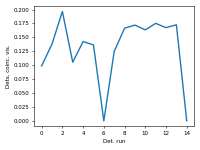

<Figure size 200x150 with 0 Axes>

Text(0.5, 0, 'Det. run')

Text(0, 0.5, 'Dets. coincidences [counts]')

<Figure size 200x150 with 0 Axes>

Text(0.5, 0, 'Det. run')

Text(0, 0.5, 'Inter time. wrap diff. [counts]')

Inter time. wrap diff. avg. [counts]: -0.5
Inter time. wrap diff. median [counts]: -1.0
Inter time. wrap diff. std [counts]: 29.662336


<Figure size 200x150 with 0 Axes>

<BarContainer object of 64 artists>

Text(0.5, 0, 'Hist. bins')

Text(0, 0.5, 'Hist. Inter time. wrap diff. [counts]')

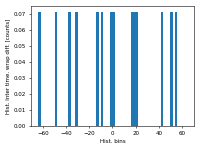

In [5]:
# Analysis of interference - Visibility & Coincidence
clear_output(wait=True)
gc.collect() # Garbage collector to avoid kernel crashes
# It has to be used PRUassTrigSigScriptHist4Sig in PRU1
# Attention TimeTaggsDetAnalytics[4] stores the multiple coincides in all channels
ExtraDetailString='PTP'#'NoPTP'# 'NTP'#'PTP'
HistPeriodicityAux=PeriodSignalHistVal# Histogram analysis periodicity
ListNumStoredQubitsNode=np.load(pathScriptData+'DealerMultiInterferenceListNumStoredQubitsNode'+ExtraDetailString+'.npy')
NonZeroIndecesDet=np.where(ListNumStoredQubitsNode>0)[0]
ListNumStoredQubitsNode=ListNumStoredQubitsNode[NonZeroIndecesDet]
ListStatisticsTimeTaggDetQubitsNodeParam4=(np.load(pathScriptData+'DealerMultiInterferenceListNumStoredQubitsMultiNode'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]

plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(ListStatisticsTimeTaggDetQubitsNodeParam4/NumRequestedQubitsReceive)
plt.xlabel('Det. run')
plt.ylabel('Dets. coinc. vis.')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'MeasInterferenceVis4Channel.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
#clear_output(wait=True)

plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(ListStatisticsTimeTaggDetQubitsNodeParam4)
plt.xlabel('Det. run')
plt.ylabel('Dets. coincidences [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'MeasInterferenceCoincidence4Channel.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
#clear_output(wait=True)

# Checking with wrapping
ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'DealerMultiInterferenceListNumStoredQubitsTabsNode'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
IntraRunSynchChecker=np.zeros(len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,dtype=np.float32)
for iIter in range(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1):    
    # Relative difference
    #CalcAux=ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+1]-ListStatisticsTimeTaggDetQubitsNodeParam7[1*iIter]
    # Absolute difference with first tag
    #CalcAux=ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+1]-ListStatisticsTimeTaggDetQubitsNodeParam7[0*iIter]
    # Absolute difference
    CalcAux=ListStatisticsTimeTaggDetQubitsNodeParam7[iIter]
    #NumCycles=np.round(CalcAux/HistPeriodicityAux)
    IntraRunSynchChecker[iIter]=(np.mod(HistPeriodicityAux/2.0+CalcAux,HistPeriodicityAux)-HistPeriodicityAux/2.0)
    #if (iIter>0):
    #    print(IntraRunSynchChecker[iIter]-IntraRunSynchChecker[0+0*iIter])
HistAuxNodeIntraRunSynchChecker=IntraRunSynchChecker
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1),IntraRunSynchChecker)
plt.xlabel('Det. run')
plt.ylabel('Inter time. wrap diff. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
#clear_output(wait=True)

def remove_outliers_func(data, method='std', threshold=1.5):
    """
    Removes outliers from a NumPy array.

    Args:
        data: The input NumPy array.
        method: The method to use for outlier detection. 
                Options: 'iqr' (Interquartile Range), 'std' (Standard Deviation).
                Default: 'iqr'.
        threshold: The threshold for outlier detection. 
                For 'iqr', it's the number of IQRs to consider as outliers.
                For 'std', it's the number of standard deviations to consider as outliers.
                Default: 1.5.

    Returns:
        A NumPy array with outliers removed.
    """

    if method == 'iqr':
        q1, q3 = np.percentile(data, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr
        return data[(data >= lower_bound) & (data <= upper_bound)]

    elif method == 'std':
        mean = np.mean(data)
        std_dev = np.std(data)
        lower_bound = mean - threshold * std_dev
        upper_bound = mean + threshold * std_dev
        return data[(data >= lower_bound) & (data <= upper_bound)]

    else:
        raise ValueError("Invalid method. Choose 'iqr' or 'std'.")

print('Inter time. wrap diff. avg. [counts]: '+str(np.mean(IntraRunSynchChecker)))
print('Inter time. wrap diff. median [counts]: '+str(np.median(IntraRunSynchChecker)))
print('Inter time. wrap diff. std [counts]: '+str(np.std(remove_outliers_func(IntraRunSynchChecker))))

# Histogram analysis
# Define the number of bins and periodicity
num_bins = 8
periodicity = HistPeriodicityAux

# Calculate the bins edges
bin_edges = np.linspace(-periodicity/2, periodicity/2, 8*num_bins+1)

# Calculate bin centers from edges for plotting
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Generate histogram data with normalization
hist1, bins1 = np.histogram(HistAuxNodeIntraRunSynchChecker, bins=bin_edges, density=True)
#hist2, bins2 = np.histogram(HistAuxNode2IntraRunSynchChecker, bins=bin_edges, density=True)

plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.bar(bin_centers, hist1/np.sum(hist1),width=(bin_edges[1] - bin_edges[0]))#, density=True)
#plt.bar(bin_centers, hist2/np.sum(hist2),width=(bin_edges[1] - bin_edges[0]))#, density=True)
plt.xlabel('Hist. bins')
plt.ylabel('Hist. Inter time. wrap diff. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'MeasHistSynchCoincChannel.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
#clear_output(wait=True)

In [ ]:
####### Testing multi-step offset variation synch protocol
# The GPIO c++ unskewing and threshold values are set to zero
# Only channel 1 is connected
# PRU1 PRUassTrigSigScriptHist4Sig.p is used
# PTP protocol better enabled
# Tags statistics  in QPhysLayer c++ is modified to this particular case
# In QPLA turn ApplyProcQubitsSmallTimeOffsetContinuousCorrection to false

In [ ]:
import time
NumTestMax = 250
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
FreqPRUarrayTest=np.asarray([0.0,-0.25,0.25])
for iIterTest in range(0,NumTestMax,1):    
    # Sending request
    SynchPRUoffFreqVal=np.asarray([0.0,FreqPRUarrayTest[int(np.floor(iIterTest/(NumTestMax/len(FreqPRUarrayTest))))]])# Double value to adjust synch signals offset and frequency for each quantum channel
    PeriodSignalHistVal=4096.0# Histogram/Period sending/receiving signals. Power of 2!
    NumRequestedQubitsSend=65536 # Qubits to send
    NumRequestedQubitsReceive=1964# Qubits signals to detect
    
    QuadChEmtDet=np.asarray([2,1]) # Emit, Detect
    argsPayloadBlockUnblockList=[IPhostClientOpNet]
    QPLAagent.WaitUntilActiveActionFreePreLock(argsPayloadBlockUnblockList)
    QPLAagent.SimulateRequestQubitsHost(IPhostClientOpNet,IPhostDealerOpNet,IPnodeDealerConNet,IPhostDealerOpNet,NumRequestedQubitsSend,NumRequestedQubitsReceive,PeriodSignalHistVal,SynchPRUoffFreqVal,QuadChEmtDet) # Request that host's node sends qubits to this host's node
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeDealerConNet,IPhostDealerConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    QPLAagent.UnBlockActiveActionFreePreLock(argsPayloadBlockUnblockList)
    
    #QuadChEmtDet=np.asarray([2,1]) # Emit, Detect
    #argsPayloadBlockUnblockList=[IPhostServerOpNet]
    #QPLAagent.WaitUntilActiveActionFreePreLock(argsPayloadBlockUnblockList)
    #QPLAagent.SimulateRequestQubitsHost(IPhostServerOpNet,IPhostDealerOpNet,IPnodeDealerConNet,IPhostDealerOpNet,NumRequestedQubitsSend,NumRequestedQubitsReceive,PeriodSignalHistVal,SynchPRUoffFreqVal,QuadChEmtDet) # Request that host's node sends qubits to this host's node
    #NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    #StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    #QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeDealerConNet,IPhostDealerConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    #QPLAagent.UnBlockActiveActionFreePreLock(argsPayloadBlockUnblockList)
    
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(10.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
    clear_output(wait=True)
    print("iIterTest: " +str(iIterTest+1))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

In [ ]:
# Save generated data
clear_output(wait=True)
ExtraDetailString='PTPfreqHist'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'DealerListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'DealerListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'DealerListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'DealerListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'DealerListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'DealerListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'DealerListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)

In [ ]:
## Synchronization analysis inter and intra runs
clear_output(wait=True)
gc.collect() # Garbage collector to avoid kernel crashes
# Connect on the timetagg part only channel 1
# It has to be used PRUassTrigSigScriptHist4Sig in PRU1
# Attention TimeTaggsDetAnalytics[5] stores the mean wrap count difference
# Attention TimeTaggsDetAnalytics[6] stores the std wrap count difference
ExtraDetailString='PTPfreqHist'#'NoPTP'# 'NTP'#'PTP'
HistPeriodicityAux=PeriodSignalHistVal# Histogram analysis periodicity
ListNumStoredQubitsNode=np.load(pathScriptData+'DealerListNumStoredQubitsNode'+ExtraDetailString+'.npy')
NonZeroIndecesDet=np.where(ListNumStoredQubitsNode>0)[0]
ListStatisticsTimeTaggDetQubitsNodeParam5=(np.load(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam5),1),ListStatisticsTimeTaggDetQubitsNodeParam5)
plt.xlabel('Det. run')
plt.ylabel('Intra time. wrap diff. avg. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

ListStatisticsTimeTaggDetQubitsNodeParam6=(np.load(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam6),1),ListStatisticsTimeTaggDetQubitsNodeParam6)
plt.xlabel('Det. run')
plt.ylabel('Intra time. wrap diff. Std [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

print('Intra time. wrap diff. avg. [counts]: '+str(np.mean(ListStatisticsTimeTaggDetQubitsNodeParam5)))
print('Intra time. wrap diff. median [counts]: '+str(np.median(ListStatisticsTimeTaggDetQubitsNodeParam5)))
print('Intra time. wrap diff. std [counts]: '+str(np.mean(ListStatisticsTimeTaggDetQubitsNodeParam6)))

# Histogram analysis
# Define the number of bins and periodicity
num_bins = 8
periodicity = HistPeriodicityAux

# Calculate the bins edges
bin_edges = np.linspace(-periodicity/2, periodicity/2, 8*num_bins+1)

# Calculate bin centers from edges for plotting
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Generate histogram data with normalization
hist, bins = np.histogram(ListStatisticsTimeTaggDetQubitsNodeParam5, bins=bin_edges, density=True)

plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.bar(bin_centers, hist/np.sum(hist),width=(bin_edges[1] - bin_edges[0]))#, density=True)
plt.xlabel('Hist. bins')
plt.ylabel('Hist. Intra time. wrap diff. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

#Inter runs checker of the initial detection in channel 1
# The plot below helps adjust the Threshold value (we should a constantly increasing line - never a decrease jump)
# If the first out of place is a up-bump->threshold value too high
# If the first out of place is a down-bump->threshold value too low
ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(1,len(ListStatisticsTimeTaggDetQubitsNodeParam7),1),ListStatisticsTimeTaggDetQubitsNodeParam7[1:])
plt.xlabel('Det. run')
plt.ylabel('Inter time. abs. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
IntraRunSynchChecker=np.zeros(len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,dtype=np.float32)
for iIter in range(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1):    
    IntraRunSynchChecker[iIter]=ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+1]-ListStatisticsTimeTaggDetQubitsNodeParam7[0*iIter]
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1),IntraRunSynchChecker)
plt.xlabel('Det. run')
plt.ylabel('Inter time. diff. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
IntraRunSynchChecker=np.zeros(len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,dtype=np.float32)
for iIter in range(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1):
    CalcAux=ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+1]-ListStatisticsTimeTaggDetQubitsNodeParam7[0*iIter]
    #print('CalcAux: '+str(CalcAux))
    NumCycles=np.round(CalcAux/HistPeriodicityAux)
    #print('NumCycles: '+str(NumCycles))
    IntraRunSynchChecker[iIter]=(np.mod(HistPeriodicityAux/2.0+CalcAux,HistPeriodicityAux)-HistPeriodicityAux/2.0)
    #print('IntraRunSynchChecker[iIter]: '+str(IntraRunSynchChecker[iIter]))
    #print(CalcAux/NumCycles)
    #if (iIter>0):
    #    print(IntraRunSynchChecker[iIter]-IntraRunSynchChecker[0+0*iIter])
HistAuxIntraRunSynchChecker=IntraRunSynchChecker
plt.figure(figsize=(4, 3),dpi=50)#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1),IntraRunSynchChecker)
plt.xlabel('Det. run')
plt.ylabel('Inter time. wrap diff. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
#plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
#plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
clear_output(wait=True)

print('Inter time. wrap diff. avg. [counts]: '+str(np.mean(IntraRunSynchChecker)))
print('Inter time. wrap diff. median [counts]: '+str(np.median(IntraRunSynchChecker)))
print('Inter time. wrap diff. std [counts]: '+str(np.std(IntraRunSynchChecker)))

# Histogram analysis
# Define the number of bins and periodicity
num_bins = 8
periodicity = HistPeriodicityAux

# Calculate the bins edges
bin_edges = np.linspace(-periodicity/2, periodicity/2, 8*num_bins+1)

# Calculate bin centers from edges for plotting
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Generate histogram data with normalization
hist, bins = np.histogram(HistAuxIntraRunSynchChecker, bins=bin_edges, density=True)

num_macro_bins= 3
colors_array=['indigo','blue','darkgreen']

### Generate nice legend
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('figure', figsize=[6.4, 4.8])     # controls default Fgiure size. Default is [6.4, 4.8]
plt.rc('figure', autolayout = True)      # code will produce the same graphs on differently-configured machines
plt.rc('font', size=SMALL_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', linewidth=1) # line width
plt.rc('lines', markersize=6) # marker size

lineArray=[]# List
plt.figure(figsize=(6.4, 4.8))
ax = plt.gca()
for iIterMacroBins in range(num_macro_bins):
    lineAux=plt.bar(bin_centers[int((iIterMacroBins)*(len(bin_centers)/num_macro_bins)):int((iIterMacroBins+1)*(len(bin_centers)/num_macro_bins))], hist[int((iIterMacroBins)*(len(hist)/num_macro_bins)):int((iIterMacroBins+1)*(len(hist)/num_macro_bins))]/np.sum(hist[int((iIterMacroBins)*(len(hist)/num_macro_bins)):int((iIterMacroBins+1)*(len(hist)/num_macro_bins))]),width=(bin_edges[1] - bin_edges[0]),color=colors_array[iIterMacroBins])
    lineArray.append(lineAux)
plt.xlabel('Hist. bins')
plt.ylabel('Hist. Inter time. wrap diff. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.legend((lineArray[0],lineArray[1],lineArray[2]),('Meas. Freq. 1','Meas. Freq. 2','Meas. Freq. 3'),loc="best",shadow=False,fancybox=False,frameon=False,fontsize='small')
#plt.tight_layout()
#plt.savefig(pathScriptData+'MeasHistSynchProtAux.eps', bbox_inches='tight', format = 'eps', dpi = 300 )#dpi = 600 )
plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
#clear_output(wait=True)

GeneralSettingsPlots()

In [ ]:
####### Performance multi-step offset variation synch protocol
# The GPIO c++ unskewing and threshold values are set to zero
# Only channel 1 is connected
# PRU1 PRUassTrigSigScriptHist4Sig.p is used
# PTP protocol better enabled
# Tags statistics  in QPhysLayer c++ is modified to this particular case
# In QPLA turn ApplyProcQubitsSmallTimeOffsetContinuousCorrection to false

In [ ]:
# Trying to retrieve different situations of offset, and relative frequency offset with respect none of them present
# Situation 1: No offset and no relative frequency offset - calculated in the cells above as ExtraDetailString='PTP'
# Situation 2: A certain offset but no relative frequency offset
# Situation 3: Offset and relative frequency offset present
import time
NumTestMax = 500
# Situation 2: Offset but no relative frequency offset
OffsetSit2=0.25
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
FreqPRUarrayTest=np.asarray([0.0,-0.25,0.25])
for iIterTest in range(0,NumTestMax,1):    
    # Sending request
    QuadChEmtDet=np.asarray([1,2]) # Emit, Detect
    SynchPRUoffFreqVal=np.asarray([OffsetSit2,0])# Double value to adjust synch signals offset and frequency for each quantum channel
    PeriodSignalHistVal=4096.0# Histogram/Period sending/receiving signals. Power of 2!
    NumRequestedQubitsSend=65536 # Qubits to send
    NumRequestedQubitsReceive=1964# Qubits signals to detect
    argsPayloadBlockUnblockList=[IPhostServerOpNet]
    QPLAagent.WaitUntilActiveActionFreePreLock(argsPayloadBlockUnblockList)
    QPLAagent.SimulateRequestQubitsHost(IPhostServerOpNet,IPhostDealerOpNet,IPnodeDealerConNet,IPhostDealerOpNet,NumRequestedQubitsSend,NumRequestedQubitsReceive,PeriodSignalHistVal,SynchPRUoffFreqVal,QuadChEmtDet) # Request that host's node sends qubits to this host's node
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeDealerConNet,IPhostDealerConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    QPLAagent.UnBlockActiveActionFreePreLock(argsPayloadBlockUnblockList)
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(10.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
    clear_output(wait=True)
    print("iIterTest: " +str(iIterTest+1))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

# Save generated data
#print(os.getcwd())
ExtraDetailString='PTPfreqOffsetSituation2Hist'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'DealerListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'DealerListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'DealerListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'DealerListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'DealerListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'DealerListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'DealerListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)

# Applying routine
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
FreqPRUarrayTest=np.asarray([0.0,-0.25,0.25])
for iIterTest in range(0,NumTestMax,1):    
    # Sending request
    QuadChEmtDet=np.asarray([1,2]) # Emit, Detect
    SynchPRUoffFreqVal=np.asarray([OffsetSit2,FreqPRUarrayTest[int(np.floor(iIterTest/(NumTestMax/len(FreqPRUarrayTest))))]])# Double value to adjust synch signals offset and frequency for each quantum channel
    PeriodSignalHistVal=4096.0# Histogram/Period sending/receiving signals. Power of 2!
    NumRequestedQubitsSend=65536 # Qubits to send
    NumRequestedQubitsReceive=1964# Qubits signals to detect
    argsPayloadBlockUnblockList=[IPhostServerOpNet]
    QPLAagent.WaitUntilActiveActionFreePreLock(argsPayloadBlockUnblockList)
    QPLAagent.SimulateRequestQubitsHost(IPhostServerOpNet,IPhostDealerOpNet,IPnodeDealerConNet,IPhostDealerOpNet,NumRequestedQubitsSend,NumRequestedQubitsReceive,PeriodSignalHistVal,SynchPRUoffFreqVal,QuadChEmtDet) # Request that host's node sends qubits to this host's node
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeDealerConNet,IPhostDealerConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    QPLAagent.UnBlockActiveActionFreePreLock(argsPayloadBlockUnblockList)
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(10.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
    clear_output(wait=True)
    print("iIterTest: " +str(iIterTest+1))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

# Save generated data
#print(os.getcwd())
ExtraDetailString='PTPfreqOffsetSituation2routineHist'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'DealerListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'DealerListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'DealerListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'DealerListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'DealerListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'DealerListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'DealerListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)


# Situation 3: Offset and relative frequency offset
OffsetSit3=0.25
RelFreqOffsetSit3=0.25
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
FreqPRUarrayTest=np.asarray([0.0,-0.25,0.25])
for iIterTest in range(0,NumTestMax,1):    
    # Sending request
    QuadChEmtDet=np.asarray([1,2]) # Emit, Detect
    SynchPRUoffFreqVal=np.asarray([OffsetSit3,RelFreqOffsetSit3])# Double value to adjust synch signals offset and frequency for each quantum channel
    PeriodSignalHistVal=4096.0# Histogram/Period sending/receiving signals. Power of 2!
    NumRequestedQubitsSend=65536 # Qubits to send
    NumRequestedQubitsReceive=1964# Qubits signals to detect
    argsPayloadBlockUnblockList=[IPhostServerOpNet]
    QPLAagent.WaitUntilActiveActionFreePreLock(argsPayloadBlockUnblockList)
    QPLAagent.SimulateRequestQubitsHost(IPhostServerOpNet,IPhostDealerOpNet,IPnodeDealerConNet,IPhostDealerOpNet,NumRequestedQubitsSend,NumRequestedQubitsReceive,PeriodSignalHistVal,SynchPRUoffFreqVal,QuadChEmtDet) # Request that host's node sends qubits to this host's node
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeDealerConNet,IPhostDealerConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    QPLAagent.UnBlockActiveActionFreePreLock(argsPayloadBlockUnblockList)
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(10.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
    clear_output(wait=True)
    print("iIterTest: " +str(iIterTest+1))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

# Save generated data
#print(os.getcwd())
ExtraDetailString='PTPfreqOffsetSituation3Hist'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'DealerListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'DealerListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'DealerListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'DealerListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'DealerListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'DealerListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'DealerListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)

# Applying routine
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
FreqPRUarrayTest=np.asarray([0.0,-0.25,0.25])
for iIterTest in range(0,NumTestMax,1):    
    # Sending request
    QuadChEmtDet=np.asarray([1,2]) # Emit, Detect
    SynchPRUoffFreqVal=np.asarray([OffsetSit3,RelFreqOffsetSit3+FreqPRUarrayTest[int(np.floor(iIterTest/(NumTestMax/len(FreqPRUarrayTest))))]])# Double value to adjust synch signals offset and frequency for each quantum channel
    PeriodSignalHistVal=4096.0# Histogram/Period sending/receiving signals. Power of 2!
    NumRequestedQubitsSend=65536 # Qubits to send
    NumRequestedQubitsReceive=1964# Qubits signals to detect
    argsPayloadBlockUnblockList=[IPhostServerOpNet]
    QPLAagent.WaitUntilActiveActionFreePreLock(argsPayloadBlockUnblockList)
    QPLAagent.SimulateRequestQubitsHost(IPhostServerOpNet,IPhostDealerOpNet,IPnodeDealerConNet,IPhostDealerOpNet,NumRequestedQubitsSend,NumRequestedQubitsReceive,PeriodSignalHistVal,SynchPRUoffFreqVal,QuadChEmtDet) # Request that host's node sends qubits to this host's node
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeDealerConNet,IPhostDealerConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    QPLAagent.UnBlockActiveActionFreePreLock(argsPayloadBlockUnblockList)
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(10.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
    print("iIterTest: " +str(iIterTest+1))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

# Save generated data
#print(os.getcwd())
ExtraDetailString='PTPfreqOffsetSituation3routineHist'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'DealerListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'DealerListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'DealerListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'DealerListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'DealerListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'DealerListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'DealerListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)

In [ ]:
## Analysis of the 3 situations regarding synch offset and relative frequency offset
# Connect on the timetagg part only channel 1
# It has to be used PRUassTrigSigScriptHist4Sig in PRU1
# Attention TimeTaggsDetAnalytics[5] stores the mean wrap count difference
# Attention TimeTaggsDetAnalytics[6] stores the std wrap count difference

HistPeriodicityAux=PeriodSignalHistVal# Histogram analysis periodicity

###################################################
# Situation 1
ExtraDetailString='PTP'
ListNumStoredQubitsNode=np.load(pathScriptData+'DealerListNumStoredQubitsNode1'+ExtraDetailString+'.npy')
NonZeroIndecesDet=np.where(ListNumStoredQubitsNode>0)[0]
ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode1'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
IntraRunSynchChecker=np.zeros(len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,dtype=np.float32)
for iIter in range(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1):
    CalcAux=ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+1]-ListStatisticsTimeTaggDetQubitsNodeParam7[1*iIter]
    #print('CalcAux: '+str(CalcAux))
    NumCycles=np.round(CalcAux/HistPeriodicityAux)
    #print('NumCycles: '+str(NumCycles))
    IntraRunSynchChecker[iIter]=(np.mod(HistPeriodicityAux/2.0+CalcAux,HistPeriodicityAux)-HistPeriodicityAux/2.0)
    #print('IntraRunSynchChecker[iIter]: '+str(IntraRunSynchChecker[iIter]))
    #print(CalcAux/NumCycles)
    #if (iIter>0):
    #    print(IntraRunSynchChecker[iIter]-IntraRunSynchChecker[0+0*iIter])
HistAuxIntraRunSynchCheckerSit1=IntraRunSynchChecker

print('Inter time. wrap diff. avg. [counts]: '+str(np.mean(HistAuxIntraRunSynchCheckerSit1)))
print('Inter time. wrap diff. median [counts]: '+str(np.median(HistAuxIntraRunSynchCheckerSit1)))
print('Inter time. wrap diff. std [counts]: '+str(np.std(HistAuxIntraRunSynchCheckerSit1)))

####################################################
# Situation 2
ExtraDetailString='PTPfreqOffsetSituation2Hist'
ListNumStoredQubitsNode=np.load(pathScriptData+'DealerListNumStoredQubitsNode'+ExtraDetailString+'.npy')
NonZeroIndecesDet=np.where(ListNumStoredQubitsNode>0)[0]
ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
IntraRunSynchChecker=np.zeros(len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,dtype=np.float32)
for iIter in range(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1):
    CalcAux=ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+1]-ListStatisticsTimeTaggDetQubitsNodeParam7[1*iIter]
    #print('CalcAux: '+str(CalcAux))
    NumCycles=np.round(CalcAux/HistPeriodicityAux)
    #print('NumCycles: '+str(NumCycles))
    IntraRunSynchChecker[iIter]=(np.mod(HistPeriodicityAux/2.0+CalcAux,HistPeriodicityAux)-HistPeriodicityAux/2.0)
    #print('IntraRunSynchChecker[iIter]: '+str(IntraRunSynchChecker[iIter]))
    #print(CalcAux/NumCycles)
    #if (iIter>0):
    #    print(IntraRunSynchChecker[iIter]-IntraRunSynchChecker[0+0*iIter])
HistAuxIntraRunSynchCheckerSit2=IntraRunSynchChecker

print('Inter time. wrap diff. avg. [counts]: '+str(np.mean(HistAuxIntraRunSynchCheckerSit2)))
print('Inter time. wrap diff. median [counts]: '+str(np.median(HistAuxIntraRunSynchCheckerSit2)))
print('Inter time. wrap diff. std [counts]: '+str(np.std(HistAuxIntraRunSynchCheckerSit2)))


ExtraDetailString='PTPfreqOffsetSituation2routineHist'
ListNumStoredQubitsNode=np.load(pathScriptData+'DealerListNumStoredQubitsNode'+ExtraDetailString+'.npy')
NonZeroIndecesDet=np.where(ListNumStoredQubitsNode>0)[0]
ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
IntraRunSynchChecker=np.zeros(len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,dtype=np.float32)
for iIter in range(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1):
    CalcAux=ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+1]-ListStatisticsTimeTaggDetQubitsNodeParam7[1*iIter]
    #print('CalcAux: '+str(CalcAux))
    NumCycles=np.round(CalcAux/HistPeriodicityAux)
    #print('NumCycles: '+str(NumCycles))
    IntraRunSynchChecker[iIter]=(np.mod(HistPeriodicityAux/2.0+CalcAux,HistPeriodicityAux)-HistPeriodicityAux/2.0)
    #print('IntraRunSynchChecker[iIter]: '+str(IntraRunSynchChecker[iIter]))
    #print(CalcAux/NumCycles)
    #if (iIter>0):
    #    print(IntraRunSynchChecker[iIter]-IntraRunSynchChecker[0+0*iIter])
HistAuxIntraRunSynchCheckerSit2routine=IntraRunSynchChecker
HistAuxIntraRunSynchCheckerSit2Corrected=HistAuxIntraRunSynchCheckerSit2routine

print('Inter time. wrap diff. avg. [counts]: '+str(np.mean(HistAuxIntraRunSynchCheckerSit2Corrected)))
print('Inter time. wrap diff. median [counts]: '+str(np.median(HistAuxIntraRunSynchCheckerSit2Corrected)))
print('Inter time. wrap diff. std [counts]: '+str(np.std(HistAuxIntraRunSynchCheckerSit2Corrected)))

#####################################################
# Situation 3
ExtraDetailString='PTPfreqOffsetSituation3Hist'
ListNumStoredQubitsNode=np.load(pathScriptData+'DealerListNumStoredQubitsNode'+ExtraDetailString+'.npy')
NonZeroIndecesDet=np.where(ListNumStoredQubitsNode>0)[0]
ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
IntraRunSynchChecker=np.zeros(len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,dtype=np.float32)
for iIter in range(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1):
    CalcAux=ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+1]-ListStatisticsTimeTaggDetQubitsNodeParam7[1*iIter]
    #print('CalcAux: '+str(CalcAux))
    NumCycles=np.round(CalcAux/HistPeriodicityAux)
    #print('NumCycles: '+str(NumCycles))
    IntraRunSynchChecker[iIter]=(np.mod(HistPeriodicityAux/2.0+CalcAux,HistPeriodicityAux)-HistPeriodicityAux/2.0)
    #print('IntraRunSynchChecker[iIter]: '+str(IntraRunSynchChecker[iIter]))
    #print(CalcAux/NumCycles)
    #if (iIter>0):
    #    print(IntraRunSynchChecker[iIter]-IntraRunSynchChecker[0+0*iIter])
HistAuxIntraRunSynchCheckerSit3=IntraRunSynchChecker

print('Inter time. wrap diff. avg. [counts]: '+str(np.mean(HistAuxIntraRunSynchCheckerSit3)))
print('Inter time. wrap diff. median [counts]: '+str(np.median(HistAuxIntraRunSynchCheckerSit3)))
print('Inter time. wrap diff. std [counts]: '+str(np.std(HistAuxIntraRunSynchCheckerSit3)))

ExtraDetailString='PTPfreqOffsetSituation3routineHist'
ListNumStoredQubitsNode=np.load(pathScriptData+'DealerListNumStoredQubitsNode'+ExtraDetailString+'.npy')
NonZeroIndecesDet=np.where(ListNumStoredQubitsNode>0)[0]
ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
IntraRunSynchChecker=np.zeros(len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,dtype=np.float32)
for iIter in range(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1):
    CalcAux=ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+1]-ListStatisticsTimeTaggDetQubitsNodeParam7[1*iIter]
    #print('CalcAux: '+str(CalcAux))
    NumCycles=np.round(CalcAux/HistPeriodicityAux)
    #print('NumCycles: '+str(NumCycles))
    IntraRunSynchChecker[iIter]=(np.mod(HistPeriodicityAux/2.0+CalcAux,HistPeriodicityAux)-HistPeriodicityAux/2.0)
    #print('IntraRunSynchChecker[iIter]: '+str(IntraRunSynchChecker[iIter]))
    #print(CalcAux/NumCycles)
    #if (iIter>0):
    #    print(IntraRunSynchChecker[iIter]-IntraRunSynchChecker[0+0*iIter])
HistAuxIntraRunSynchCheckerSit3routine=IntraRunSynchChecker
HistAuxIntraRunSynchCheckerSit3Corrected=HistAuxIntraRunSynchCheckerSit3routine

print('Inter time. wrap diff. avg. [counts]: '+str(np.mean(HistAuxIntraRunSynchCheckerSit3Corrected)))
print('Inter time. wrap diff. median [counts]: '+str(np.median(HistAuxIntraRunSynchCheckerSit3Corrected)))
print('Inter time. wrap diff. std [counts]: '+str(np.std(HistAuxIntraRunSynchCheckerSit3Corrected)))

#################################################################################################
# Histogram analysis
# Define the number of bins and periodicity
num_bins = 8
periodicity = HistPeriodicityAux

# Calculate the bins edges
bin_edges = np.linspace(-periodicity/2, periodicity/2, 8*num_bins+1)

# Calculate bin centers from edges for plotting
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Generate histogram data with normalization
hist1, bins1 = np.histogram(HistAuxIntraRunSynchCheckerSit1, bins=bin_edges, density=True)
hist2, bins2 = np.histogram(HistAuxIntraRunSynchCheckerSit2, bins=bin_edges, density=True)
hist3, bins3 = np.histogram(HistAuxIntraRunSynchCheckerSit2Corrected, bins=bin_edges, density=True)
hist4, bins4 = np.histogram(HistAuxIntraRunSynchCheckerSit3, bins=bin_edges, density=True)
hist5, bins5 = np.histogram(HistAuxIntraRunSynchCheckerSit3Corrected, bins=bin_edges, density=True)

### Generate nice legend
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('figure', figsize=[6.4, 4.8])     # controls default Fgiure size. Default is [6.4, 4.8]
plt.rc('figure', autolayout = True)      # code will produce the same graphs on differently-configured machines
plt.rc('font', size=SMALL_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', linewidth=1) # line width
plt.rc('lines', markersize=6) # marker size

plt.figure(figsize=(6.4, 4.8))
ax = plt.gca()
line1=plt.bar(bin_centers, hist1/np.sum(hist1),width=(bin_edges[1] - bin_edges[0]),color='royalblue')
line2=plt.bar(bin_centers, hist2/np.sum(hist2),width=(bin_edges[1] - bin_edges[0]),color='darkgreen')
line3=plt.bar(bin_centers, hist3/np.sum(hist3),width=(bin_edges[1] - bin_edges[0]),color='forestgreen')
line4=plt.bar(bin_centers, hist4/np.sum(hist4),width=(bin_edges[1] - bin_edges[0]),color='maroon')
line5=plt.bar(bin_centers, hist5/np.sum(hist5),width=(bin_edges[1] - bin_edges[0]),color='firebrick')
plt.xlabel('Hist. bins')
plt.ylabel('Hist. Inter time. wrap diff. [counts]')
#plt.title('Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.legend((line1,line2,line3,line4,line5),('Meas. Off.=0 relF=0.0','Meas. Off.=10 relF=0.0','Corr. Off.=10 relF=0.0','Meas. Off.=10 relF=10.0','Corr. Off.=10 relF=10.0'),loc="best",shadow=False,fancybox=False,frameon=False,fontsize='small')
#plt.tight_layout()
#plt.savefig(pathScriptData+'MeasHistSynchInterChannelAux.eps', bbox_inches='tight', format = 'eps', dpi = 300 )#dpi = 600 )
plt.show()
plt.close('all')  # Closes all matplotlib figures and free resources
#clear_output(wait=True)

GeneralSettingsPlots()

In [ ]:
# For the different combination of nodes (respectively)
# Trying to retrieve different situations of offset, and relative frequency offset with respect none of them present
# Situation 1: No offset and no relative frequency offset - calculated in the cells above as ExtraDetailString='PTP'
# Situation 2: A certain offset but no relative frequency offset
# Situation 3: Offset and relative frequency offset present
# In QPLA turn ApplyProcQubitsSmallTimeOffsetContinuousCorrection to false
import time
NumTestMax = 500

## For nodes CA
# Situation 1: No offset and no relative frequency offset
OffsetSit1=0
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
FreqPRUarrayTest=np.asarray([0.0,-0.25,0.25])
for iIterTest in range(0,NumTestMax,1):    
    # Sending request
    QuadChEmtDet=np.asarray([2,1]) # Emit, Detect
    SynchPRUoffFreqVal=np.asarray([OffsetSit1,0])# Double value to adjust synch signals offset and frequency for each quantum channel
    PeriodSignalHistVal=4096.0# Histogram/Period sending/receiving signals. Power of 2!
    NumRequestedQubitsSend=65536 # Qubits to send
    NumRequestedQubitsReceive=1964# Qubits signals to detect
    argsPayloadBlockUnblockList=[IPhostClientOpNet]
    QPLAagent.WaitUntilActiveActionFreePreLock(argsPayloadBlockUnblockList)
    QPLAagent.SimulateRequestQubitsHost(IPhostClientOpNet,IPhostDealerOpNet,IPnodeDealerConNet,IPhostDealerOpNet,NumRequestedQubitsSend,NumRequestedQubitsReceive,PeriodSignalHistVal,SynchPRUoffFreqVal,QuadChEmtDet) # Request that host's node sends qubits to this host's node
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeDealerConNet,IPhostDealerConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    QPLAagent.UnBlockActiveActionFreePreLock(argsPayloadBlockUnblockList)
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(10.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

# Save generated data
#print(os.getcwd())
ExtraDetailString='PTPfreqOffsetSituation1CAHist'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'DealerListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'DealerListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'DealerListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'DealerListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'DealerListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'DealerListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'DealerListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)

# Situation 2: Offset but no relative frequency offset
OffsetSit2=0.25
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
FreqPRUarrayTest=np.asarray([0.0,-0.25,0.25])
for iIterTest in range(0,NumTestMax,1):    
    # Sending request
    QuadChEmtDet=np.asarray([2,1]) # Emit, Detect
    SynchPRUoffFreqVal=np.asarray([OffsetSit2,0])# Double value to adjust synch signals offset and frequency for each quantum channel
    PeriodSignalHistVal=4096.0# Histogram/Period sending/receiving signals. Power of 2!
    NumRequestedQubitsSend=65536 # Qubits to send
    NumRequestedQubitsReceive=1964# Qubits signals to detect
    argsPayloadBlockUnblockList=[IPhostClientOpNet]
    QPLAagent.WaitUntilActiveActionFreePreLock(argsPayloadBlockUnblockList)
    QPLAagent.SimulateRequestQubitsHost(IPhostClientOpNet,IPhostDealerOpNet,IPnodeDealerConNet,IPhostDealerOpNet,NumRequestedQubitsSend,NumRequestedQubitsReceive,PeriodSignalHistVal,SynchPRUoffFreqVal,QuadChEmtDet) # Request that host's node sends qubits to this host's node
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeDealerConNet,IPhostDealerConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    QPLAagent.UnBlockActiveActionFreePreLock(argsPayloadBlockUnblockList)
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(10.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

# Save generated data
#print(os.getcwd())
ExtraDetailString='PTPfreqOffsetSituation2CAHist'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'DealerListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'DealerListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'DealerListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'DealerListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'DealerListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'DealerListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'DealerListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)

# Applying routine
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
FreqPRUarrayTest=np.asarray([0.0,-0.25,0.25])
for iIterTest in range(0,NumTestMax,1):    
    # Sending request
    QuadChEmtDet=np.asarray([2,1]) # Emit, Detect
    SynchPRUoffFreqVal=np.asarray([OffsetSit2,FreqPRUarrayTest[int(np.floor(iIterTest/(NumTestMax/len(FreqPRUarrayTest))))]])# Double value to adjust synch signals offset and frequency for each quantum channel
    PeriodSignalHistVal=4096.0# Histogram/Period sending/receiving signals. Power of 2!
    NumRequestedQubitsSend=65536 # Qubits to send
    NumRequestedQubitsReceive=1964# Qubits signals to detect
    argsPayloadBlockUnblockList=[IPhostClientOpNet]
    QPLAagent.WaitUntilActiveActionFreePreLock(argsPayloadBlockUnblockList)
    QPLAagent.SimulateRequestQubitsHost(IPhostClientOpNet,IPhostDealerOpNet,IPnodeDealerConNet,IPhostDealerOpNet,NumRequestedQubitsSend,NumRequestedQubitsReceive,PeriodSignalHistVal,SynchPRUoffFreqVal,QuadChEmtDet) # Request that host's node sends qubits to this host's node
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeDealerConNet,IPhostDealerConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    QPLAagent.UnBlockActiveActionFreePreLock(argsPayloadBlockUnblockList)
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(10.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

# Save generated data
#print(os.getcwd())
ExtraDetailString='PTPfreqOffsetSituation2routineCAHist'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'DealerListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'DealerListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'DealerListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'DealerListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'DealerListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'DealerListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'DealerListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)


# Situation 3: Offset and relative frequency offset
OffsetSit3=0.25
RelFreqOffsetSit3=0.25
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
FreqPRUarrayTest=np.asarray([0.0,-0.25,0.25])
for iIterTest in range(0,NumTestMax,1):    
    # Sending request
    QuadChEmtDet=np.asarray([2,1]) # Emit, Detect
    SynchPRUoffFreqVal=np.asarray([OffsetSit3,RelFreqOffsetSit3])# Double value to adjust synch signals offset and frequency for each quantum channel
    PeriodSignalHistVal=4096.0# Histogram/Period sending/receiving signals. Power of 2!
    NumRequestedQubitsSend=65536 # Qubits to send
    NumRequestedQubitsReceive=1964# Qubits signals to detect
    argsPayloadBlockUnblockList=[IPhostClientOpNet]
    QPLAagent.WaitUntilActiveActionFreePreLock(argsPayloadBlockUnblockList)
    QPLAagent.SimulateRequestQubitsHost(IPhostClientOpNet,IPhostDealerOpNet,IPnodeDealerConNet,IPhostDealerOpNet,NumRequestedQubitsSend,NumRequestedQubitsReceive,PeriodSignalHistVal,SynchPRUoffFreqVal,QuadChEmtDet) # Request that host's node sends qubits to this host's node
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeDealerConNet,IPhostDealerConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    QPLAagent.UnBlockActiveActionFreePreLock(argsPayloadBlockUnblockList)
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(10.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

# Save generated data
#print(os.getcwd())
ExtraDetailString='PTPfreqOffsetSituation3CAHist'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'DealerListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'DealerListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'DealerListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'DealerListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'DealerListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'DealerListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'DealerListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)

# Applying routine
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
FreqPRUarrayTest=np.asarray([0.0,-0.25,0.25])
for iIterTest in range(0,NumTestMax,1):    
    # Sending request
    QuadChEmtDet=np.asarray([2,1]) # Emit, Detect
    SynchPRUoffFreqVal=np.asarray([OffsetSit3,RelFreqOffsetSit3+FreqPRUarrayTest[int(np.floor(iIterTest/(NumTestMax/len(FreqPRUarrayTest))))]])# Double value to adjust synch signals offset and frequency for each quantum channel
    PeriodSignalHistVal=4096.0# Histogram/Period sending/receiving signals. Power of 2!
    NumRequestedQubitsSend=65536 # Qubits to send
    NumRequestedQubitsReceive=1964# Qubits signals to detect
    argsPayloadBlockUnblockList=[IPhostClientOpNet]
    QPLAagent.WaitUntilActiveActionFreePreLock(argsPayloadBlockUnblockList)
    QPLAagent.SimulateRequestQubitsHost(IPhostClientOpNet,IPhostDealerOpNet,IPnodeDealerConNet,IPhostDealerOpNet,NumRequestedQubitsSend,NumRequestedQubitsReceive,PeriodSignalHistVal,SynchPRUoffFreqVal,QuadChEmtDet) # Request that host's node sends qubits to this host's node
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeDealerConNet,IPhostDealerConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    QPLAagent.UnBlockActiveActionFreePreLock(argsPayloadBlockUnblockList)
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(10.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

# Save generated data
#print(os.getcwd())
ExtraDetailString='PTPfreqOffsetSituation3routineCAHist'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'DealerListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'DealerListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'DealerListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'DealerListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'DealerListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'DealerListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'DealerListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)

#####################################
# For nodes CB
# Situation 1: No offset and no relative frequency offset
OffsetSit1=0
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
FreqPRUarrayTest=np.asarray([0.0,-0.25,0.25])
for iIterTest in range(0,NumTestMax,1):    
    # Sending request
    QuadChEmtDet=np.asarray([1,2]) # Emit, Detect
    SynchPRUoffFreqVal=np.asarray([OffsetSit1,0])# Double value to adjust synch signals offset and frequency for each quantum channel
    PeriodSignalHistVal=4096.0# Histogram/Period sending/receiving signals. Power of 2!
    NumRequestedQubitsSend=65536 # Qubits to send
    NumRequestedQubitsReceive=1964# Qubits signals to detect
    argsPayloadBlockUnblockList=[IPhostServerOpNet]
    QPLAagent.WaitUntilActiveActionFreePreLock(argsPayloadBlockUnblockList)
    QPLAagent.SimulateRequestQubitsHost(IPhostServerOpNet,IPhostDealerOpNet,IPnodeDealerConNet,IPhostDealerOpNet,NumRequestedQubitsSend,NumRequestedQubitsReceive,PeriodSignalHistVal,SynchPRUoffFreqVal,QuadChEmtDet) # Request that host's node sends qubits to this host's node
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeDealerConNet,IPhostDealerConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    QPLAagent.UnBlockActiveActionFreePreLock(argsPayloadBlockUnblockList)
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(10.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

# Save generated data
#print(os.getcwd())
ExtraDetailString='PTPfreqOffsetSituation1CBHist'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'DealerListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'DealerListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'DealerListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'DealerListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'DealerListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'DealerListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'DealerListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)

# Situation 2: Offset but no relative frequency offset
OffsetSit2=0.25
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
FreqPRUarrayTest=np.asarray([0.0,-0.25,0.25])
for iIterTest in range(0,NumTestMax,1):    
    # Sending request
    QuadChEmtDet=np.asarray([1,2]) # Emit, Detect
    SynchPRUoffFreqVal=np.asarray([OffsetSit2,0])# Double value to adjust synch signals offset and frequency for each quantum channel
    PeriodSignalHistVal=4096.0# Histogram/Period sending/receiving signals. Power of 2!
    NumRequestedQubitsSend=65536 # Qubits to send
    NumRequestedQubitsReceive=1964# Qubits signals to detect
    argsPayloadBlockUnblockList=[IPhostServerOpNet]
    QPLAagent.WaitUntilActiveActionFreePreLock(argsPayloadBlockUnblockList)
    QPLAagent.SimulateRequestQubitsHost(IPhostServerOpNet,IPhostDealerOpNet,IPnodeDealerConNet,IPhostDealerOpNet,NumRequestedQubitsSend,NumRequestedQubitsReceive,PeriodSignalHistVal,SynchPRUoffFreqVal,QuadChEmtDet) # Request that host's node sends qubits to this host's node
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeDealerConNet,IPhostDealerConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    QPLAagent.UnBlockActiveActionFreePreLock(argsPayloadBlockUnblockList)
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(10.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

# Save generated data
#print(os.getcwd())
ExtraDetailString='PTPfreqOffsetSituation2CBHist'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'DealerListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'DealerListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'DealerListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'DealerListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'DealerListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'DealerListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'DealerListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)

# Applying routine
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
FreqPRUarrayTest=np.asarray([0.0,-0.25,0.25])
for iIterTest in range(0,NumTestMax,1):    
    # Sending request
    QuadChEmtDet=np.asarray([1,2]) # Emit, Detect
    SynchPRUoffFreqVal=np.asarray([OffsetSit2,FreqPRUarrayTest[int(np.floor(iIterTest/(NumTestMax/len(FreqPRUarrayTest))))]])# Double value to adjust synch signals offset and frequency for each quantum channel
    PeriodSignalHistVal=4096.0# Histogram/Period sending/receiving signals. Power of 2!
    NumRequestedQubitsSend=65536 # Qubits to send
    NumRequestedQubitsReceive=1964# Qubits signals to detect
    argsPayloadBlockUnblockList=[IPhostServerOpNet]
    QPLAagent.WaitUntilActiveActionFreePreLock(argsPayloadBlockUnblockList)
    QPLAagent.SimulateRequestQubitsHost(IPhostServerOpNet,IPhostDealerOpNet,IPnodeDealerConNet,IPhostDealerOpNet,NumRequestedQubitsSend,NumRequestedQubitsReceive,PeriodSignalHistVal,SynchPRUoffFreqVal,QuadChEmtDet) # Request that host's node sends qubits to this host's node
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeDealerConNet,IPhostDealerConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    QPLAagent.UnBlockActiveActionFreePreLock(argsPayloadBlockUnblockList)
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(10.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

# Save generated data
#print(os.getcwd())
ExtraDetailString='PTPfreqOffsetSituation2routineCBHist'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'DealerListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'DealerListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'DealerListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'DealerListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'DealerListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'DealerListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'DealerListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)


# Situation 3: Offset and relative frequency offset
OffsetSit3=0.25
RelFreqOffsetSit3=0.25
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
FreqPRUarrayTest=np.asarray([0.0,-0.25,0.25])
for iIterTest in range(0,NumTestMax,1):    
    # Sending request
    QuadChEmtDet=np.asarray([1,2]) # Emit, Detect
    SynchPRUoffFreqVal=np.asarray([OffsetSit3,RelFreqOffsetSit3])# Double value to adjust synch signals offset and frequency for each quantum channel
    PeriodSignalHistVal=4096.0# Histogram/Period sending/receiving signals. Power of 2!
    NumRequestedQubitsSend=65536 # Qubits to send
    NumRequestedQubitsReceive=1964# Qubits signals to detect
    argsPayloadBlockUnblockList=[IPhostServerOpNet]
    QPLAagent.WaitUntilActiveActionFreePreLock(argsPayloadBlockUnblockList)
    QPLAagent.SimulateRequestQubitsHost(IPhostServerOpNet,IPhostDealerOpNet,IPnodeDealerConNet,IPhostDealerOpNet,NumRequestedQubitsSend,NumRequestedQubitsReceive,PeriodSignalHistVal,SynchPRUoffFreqVal,QuadChEmtDet) # Request that host's node sends qubits to this host's node
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeDealerConNet,IPhostDealerConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    QPLAagent.UnBlockActiveActionFreePreLock(argsPayloadBlockUnblockList)
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(10.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

# Save generated data
#print(os.getcwd())
ExtraDetailString='PTPfreqOffsetSituation3CBHist'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'DealerListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'DealerListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'DealerListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'DealerListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'DealerListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'DealerListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'DealerListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)

# Applying routine
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
FreqPRUarrayTest=np.asarray([0.0,-0.25,0.25])
for iIterTest in range(0,NumTestMax,1):    
    # Sending request
    QuadChEmtDet=np.asarray([1,2]) # Emit, Detect
    SynchPRUoffFreqVal=np.asarray([OffsetSit3,RelFreqOffsetSit3+FreqPRUarrayTest[int(np.floor(iIterTest/(NumTestMax/len(FreqPRUarrayTest))))]])# Double value to adjust synch signals offset and frequency for each quantum channel
    PeriodSignalHistVal=4096.0# Histogram/Period sending/receiving signals. Power of 2!
    NumRequestedQubitsSend=65536 # Qubits to send
    NumRequestedQubitsReceive=1964# Qubits signals to detect
    argsPayloadBlockUnblockList=[IPhostServerOpNet]
    QPLAagent.WaitUntilActiveActionFreePreLock(argsPayloadBlockUnblockList)
    QPLAagent.SimulateRequestQubitsHost(IPhostServerOpNet,IPhostDealerOpNet,IPnodeDealerConNet,IPhostDealerOpNet,NumRequestedQubitsSend,NumRequestedQubitsReceive,PeriodSignalHistVal,SynchPRUoffFreqVal,QuadChEmtDet) # Request that host's node sends qubits to this host's node
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeDealerConNet,IPhostDealerConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    QPLAagent.UnBlockActiveActionFreePreLock(argsPayloadBlockUnblockList)
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(10.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

# Save generated data
#print(os.getcwd())
ExtraDetailString='PTPfreqOffsetSituation3routineCBHist'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'DealerListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'DealerListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'DealerListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'DealerListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'DealerListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'DealerListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'DealerListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)